# Climate Impact Project Data Extraction, Cleaning and Regression Analysis

This python notebook contains the functions for all the data requests made to the NASS (National Agricultral Statistics Service) Quick Stats API.The data is being requested from the SURVEY program and CROP sector.

Each function is designed to request the neccessary data for corn, cotton and soy crops.  Below is are the contents being requested:

## Corn
- **Category: YEILD**
    - Commodity = CORN
    - Data Item = CORN, GRAIN - YIELD, MEASURED IN BU / ACRE (*Corn "grain" is selected here to only bring in the grain data vs silage)
    - Geographic Level = State
    - Time: > 1989

- **Category: Area Planted**
    - Commodity = Corn
    - Data Item(s) = CORN - ACRES PLANTED
    - Geographic Level = State
    - Time: >1989

## Soybean
- **Category: YEILD**
    - Commodity = SOYBEANS
    - Data Item = SOYBEANS - YIELD MEASURED IN BU / ACRE
    - Geographic Level = State
    - Time: > 1989

- **Category: Area Planted**
    - Commodity = SOYBEANS
    - Data Item(s) = SOYBEANS - ACRES PLANTED
    - Geographic Level = State
    - Time: >1989

## Cotton

- **Category: YEILD**
    - Commodity = COTTON
    - Data Item = COTTON, UPLAND - YIELD, MEASURED IN LB / ACRE
    - Geographic Level = County
    - Time: > 1989

- **Category: Area Planted**
    - Commodity = COTTON
    - Data Item(s) = COTTON, UPLAND - ACRES PLANTED
    - Geographic Level = State
    - Time: > 1989
    
Also within this Notebook are imports of GE Seed data from USDA that includes the years 2000-2022 and the overall percentage of genetically engineered seeds planted for the crops corn, soybean and cotton. This data will be joined with the data extracted from NASS. The category used is "All Varieties". This data can be found here:

https://www.ers.usda.gov/data-products/adoption-of-genetically-engineered-crops-in-the-u-s/

Added after the Genetically Engineered Data, PDSI (Palmer Drought Severity Index), Avereage Temperature and Average Rainfall data is imported from the NClimDiv data archives that includes the PDSI rating for each state and each year from 1989-2022. This data can be found here:

https://www.ncei.noaa.gov/data/nclimdiv-monthly/access/



In [1]:
import warnings
warnings.filterwarnings('ignore')
import requests
import pandas as pd
import numpy as np
import missingno as ms
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib import colors
import statsmodels.formula.api as smf
from scipy.stats import linregress
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

## Extract Function

The section below contains the corn functions to request the required data from the NASS API. 

In [2]:
#Base NASS URL
nass_url = "http://quickstats.nass.usda.gov/api/"

In [3]:
#Create function to request the AREA PLANTED data from NASS
def ext_nass_data(api_key, source_desc=None, sector_desc=None, short_desc=None,reference_period_desc=None, statisticcat_desc=None, commodity_desc=None, agg_level_desc=None, year__GE=None):

# get dict of parameters
    inputs = vars()
    inputs.pop('api_key') # get rid of api_key in dict for building url, as it is hardcoded below

    # set up the url with api key
    base_url = nass_url + "api_GET?key=" + "A856AC67-CE95-3A48-9E4A-B69C6BDA9104"

    # filter dict for non-None values and add actual values to the request
    for item in list(inputs):
        if inputs[item] == None:
            inputs.pop(item)
        else:
            # make sure the desc inputs are all uppercase, and strings
            if item != 'numeric_vals':
                inputs[item] = str((inputs[item])).upper()
            
            # add on the url parameters
            base_url += '&' + item + '=' + requests.utils.quote(inputs[item]) #encodes unsafe / reserved chars in the user input (such as in ANIMALS & PRODUCTS)
    
    # make the request
    r = requests.get(base_url)
    
    # validate the response
    status = r.status_code

    if status >= 200 and status < 300:
        response_json = r.json()
        
        # success
        return pd.json_normalize(response_json, record_path="data")
    else:
        return 'Response code ' + str(status) + ': ' + r.json()['error'][0]

## Corn Data

Next we will request the corn data, load into a dataframe, clean and wrangle for the final results.

In [4]:
#run function with input parameters for AREA PLANTED
corn_planted = ext_nass_data("A856AC67-CE95-3A48-9E4A-B69C6BDA9104", source_desc="SURVEY", reference_period_desc="YEAR", sector_desc="CROPS",short_desc="CORN - ACRES PLANTED",statisticcat_desc="AREA PLANTED", commodity_desc="CORN", agg_level_desc="STATE", year__GE=1986)

In [5]:
#Check dataframe format
corn_planted.head()

,county_ansi,source_desc,zip_5,asd_code,country_name,reference_period_desc,commodity_desc,end_code,region_desc,location_desc,...,asd_desc,county_code,week_ending,domaincat_desc,congr_district_code,state_name,state_alpha,state_ansi,domain_desc,util_practice_desc
0,,SURVEY,,,UNITED STATES,YEAR,CORN,00,,OTHER STATES,...,,,,NOT SPECIFIED,,OTHER STATES,OT,,TOTAL,ALL UTILIZATION PRACTICES
1,,SURVEY,,,UNITED STATES,YEAR,CORN,00,,OTHER STATES,...,,,,NOT SPECIFIED,,OTHER STATES,OT,,TOTAL,ALL UTILIZATION PRACTICES
2,,SURVEY,,,UNITED STATES,YEAR,CORN,00,,OTHER STATES,...,,,,NOT SPECIFIED,,OTHER STATES,OT,,TOTAL,ALL UTILIZATION PRACTICES
3,,SURVEY,,,UNITED STATES,YEAR,CORN,00,,OTHER STATES,...,,,,NOT SPECIFIED,,OTHER STATES,OT,,TOTAL,ALL UTILIZATION PRACTICES
4,,SURVEY,,,UNITED STATES,YEAR,CORN,00,,OTHER STATES,...,,,,NOT SPECIFIED,,OTHER STATES,OT,,TOTAL,ALL UTILIZATION PRACTICES


In [6]:
#Check dataframe info
corn_planted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1815 entries, 0 to 1814
Data columns (total 39 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   county_ansi            1815 non-null   object
 1   source_desc            1815 non-null   object
 2   zip_5                  1815 non-null   object
 3   asd_code               1815 non-null   object
 4   country_name           1815 non-null   object
 5   reference_period_desc  1815 non-null   object
 6   commodity_desc         1815 non-null   object
 7   end_code               1815 non-null   object
 8   region_desc            1815 non-null   object
 9   location_desc          1815 non-null   object
 10  unit_desc              1815 non-null   object
 11  begin_code             1815 non-null   object
 12  watershed_desc         1815 non-null   object
 13  freq_desc              1815 non-null   object
 14  class_desc             1815 non-null   object
 15  statisticcat_desc    

In [7]:
#checking the data items requested are correct
corn_planted.short_desc.unique()

array(['CORN - ACRES PLANTED'], dtype=object)

### Corn Pivot

Next step is to pivot the data so we can have the CORN - ACRES PLANTED values in their own column. This is neccessary to join the later data and for better function is visualizations.

In [8]:
#pivot the dataframe
corn_pivot1 = corn_planted.pivot(index=["state_name", "year"], columns=["short_desc"], values=["Value"]).reset_index()

In [9]:
#check the data format
corn_pivot1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1815 entries, 0 to 1814
Data columns (total 3 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   (state_name, )                 1815 non-null   object
 1   (year, )                       1815 non-null   int64 
 2   (Value, CORN - ACRES PLANTED)  1815 non-null   object
dtypes: int64(1), object(2)
memory usage: 42.7+ KB


### Flatten the Index

After the pivot, a multi-level index was created. Next we will flatten the index and rename the columns.

In [10]:
#flattening the index
corn_pivot1.columns = ["_".join(tup) for tup in corn_pivot1.columns.to_flat_index()]
corn_pivot1.reset_index()

,index,state_name_,year_,Value_CORN - ACRES PLANTED
0,0,ALABAMA,1986,"340,000"
1,1,ALABAMA,1987,"300,000"
2,2,ALABAMA,1988,"240,000"
3,3,ALABAMA,1989,"230,000"
4,4,ALABAMA,1990,"290,000"
...,...,...,...,...
1810,1810,WYOMING,2019,"95,000"
1811,1811,WYOMING,2020,"95,000"
1812,1812,WYOMING,2021,"95,000"
1813,1813,WYOMING,2022,"95,000"


In [11]:
#Renaming columns 
corn_pivot1 = corn_pivot1.rename(columns={"state_name_": "state_name", "year_": "year", "Value_CORN - ACRES PLANTED": "acres_planted"})

In [12]:
corn_pivot1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1815 entries, 0 to 1814
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   state_name     1815 non-null   object
 1   year           1815 non-null   int64 
 2   acres_planted  1815 non-null   object
dtypes: int64(1), object(2)
memory usage: 42.7+ KB


### Yield Request

Next we will request the yield data using the function corn_nass_data function created earlier.

In [13]:
#run function with input parameters for YIELD
corn_yield = ext_nass_data("A856AC67-CE95-3A48-9E4A-B69C6BDA9104", source_desc="SURVEY", reference_period_desc="YEAR", short_desc="CORN, GRAIN - YIELD, MEASURED IN BU / ACRE", sector_desc="CROPS",statisticcat_desc="YIELD", commodity_desc="CORN", agg_level_desc="STATE", year__GE=1986)

In [14]:
#Check dataframe format
corn_yield.head()

,short_desc,state_fips_code,state_alpha,location_desc,CV (%),county_name,congr_district_code,county_ansi,load_time,week_ending,...,reference_period_desc,group_desc,freq_desc,sector_desc,watershed_desc,asd_desc,Value,statisticcat_desc,year,country_code
0,"CORN, GRAIN - YIELD, MEASURED IN BU / ACRE",98,OT,OTHER STATES,,,,,2023-01-12 12:00:00.000,,...,YEAR,FIELD CROPS,ANNUAL,CROPS,,,0,YIELD,2022,9000
1,"CORN, GRAIN - YIELD, MEASURED IN BU / ACRE",98,OT,OTHER STATES,,,,,2021-01-19 08:46:26.000,,...,YEAR,FIELD CROPS,ANNUAL,CROPS,,,0,YIELD,2020,9000
2,"CORN, GRAIN - YIELD, MEASURED IN BU / ACRE",98,OT,OTHER STATES,,,,,2020-01-10 12:00:41.000,,...,YEAR,FIELD CROPS,ANNUAL,CROPS,,,0,YIELD,2018,9000
3,"CORN, GRAIN - YIELD, MEASURED IN BU / ACRE",98,OT,OTHER STATES,,,,,2018-01-12 12:02:42.000,,...,YEAR,FIELD CROPS,ANNUAL,CROPS,,,0,YIELD,2017,9000
4,"CORN, GRAIN - YIELD, MEASURED IN BU / ACRE",98,OT,OTHER STATES,,,,,2018-01-12 12:02:42.000,,...,YEAR,FIELD CROPS,ANNUAL,CROPS,,,0,YIELD,2016,9000


In [15]:
#Check dataframe info
corn_yield.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1523 entries, 0 to 1522
Data columns (total 39 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   short_desc             1523 non-null   object
 1   state_fips_code        1523 non-null   object
 2   state_alpha            1523 non-null   object
 3   location_desc          1523 non-null   object
 4   CV (%)                 1523 non-null   object
 5   county_name            1523 non-null   object
 6   congr_district_code    1523 non-null   object
 7   county_ansi            1523 non-null   object
 8   load_time              1523 non-null   object
 9   week_ending            1523 non-null   object
 10  domaincat_desc         1523 non-null   object
 11  county_code            1523 non-null   object
 12  asd_code               1523 non-null   object
 13  zip_5                  1523 non-null   object
 14  watershed_code         1523 non-null   object
 15  state_ansi           

### Corn Yield Pivot

Next step is to pivot the data so we can have the CORN, GRAIN - YIELD values in their own column. This is neccessary to join the later data and for better function is visualizations. Also we will be dropping the rest of the columns in this step as they are not neccessary for the analysis.

In [16]:
#pivot the dataframe
corn_pivot2 = corn_yield.pivot(index=["state_name", "year"], columns=["short_desc"], values=["Value"]).reset_index()

In [17]:
corn_pivot2.head()

,state_name,year,Value
short_desc,,,"CORN, GRAIN - YIELD, MEASURED IN BU / ACRE"
0,ALABAMA,1986,57
1,ALABAMA,1987,72
2,ALABAMA,1988,44
3,ALABAMA,1989,81
4,ALABAMA,1990,58


### Flatten the Index

After the pivot, a multi-level index was created. Next we will flatten the index and rename the columns.

In [18]:
#flattening the index
corn_pivot2.columns = ["_".join(tup) for tup in corn_pivot2.columns.to_flat_index()]
corn_pivot2.reset_index()

,index,state_name_,year_,"Value_CORN, GRAIN - YIELD, MEASURED IN BU / ACRE"
0,0,ALABAMA,1986,57
1,1,ALABAMA,1987,72
2,2,ALABAMA,1988,44
3,3,ALABAMA,1989,81
4,4,ALABAMA,1990,58
...,...,...,...,...
1518,1518,WYOMING,2018,164
1519,1519,WYOMING,2019,123
1520,1520,WYOMING,2020,122
1521,1521,WYOMING,2021,132


In [19]:
#Renaming columns 
corn_pivot2 = corn_pivot2.rename(columns={"state_name_": "state_name", "year_": "year", "Value_CORN, GRAIN - YIELD, MEASURED IN BU / ACRE": "yield"})

In [20]:
corn_pivot2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1523 entries, 0 to 1522
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   state_name  1523 non-null   object
 1   year        1523 non-null   int64 
 2   yield       1523 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.8+ KB


In [21]:
#combine the corn_yeild and corn_planted dataframes into one
nass_corn_data1 =  pd.merge(corn_pivot1, corn_pivot2, on =["year", "state_name"], how ='outer')

In [22]:
nass_corn_data1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1816 entries, 0 to 1815
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   state_name     1816 non-null   object
 1   year           1816 non-null   int64 
 2   acres_planted  1815 non-null   object
 3   yield          1523 non-null   object
dtypes: int64(1), object(3)
memory usage: 70.9+ KB


In [23]:
is_nan2 = nass_corn_data1[nass_corn_data1.isnull().any(axis=1)]
print(is_nan2)

         state_name  year acres_planted yield
37          ALABAMA  2023       360,000   NaN
75          ARIZONA  2023       100,000   NaN
113        ARKANSAS  2023       890,000   NaN
151      CALIFORNIA  2023       390,000   NaN
189        COLORADO  2023     1,250,000   NaN
...             ...   ...           ...   ...
1700     WASHINGTON  2023       180,000   NaN
1738  WEST VIRGINIA  2023        57,000   NaN
1776      WISCONSIN  2023     4,000,000   NaN
1814        WYOMING  2023        95,000   NaN
1815   OTHER STATES  2020           NaN     0

[294 rows x 4 columns]


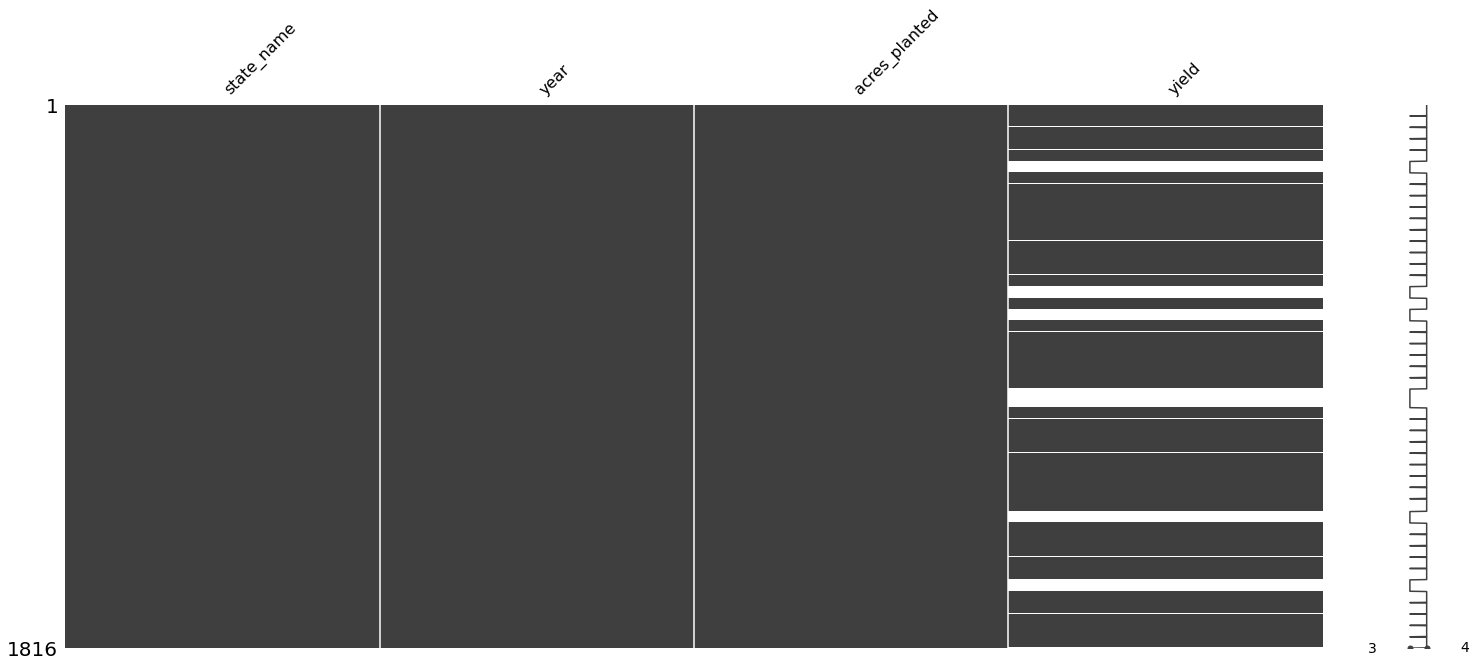

In [24]:
ms.matrix(nass_corn_data1);

In [25]:
yield_missing = nass_corn_data1[nass_corn_data1.isnull().any(axis=1)]
missing_sum = yield_missing["state_name"].value_counts()
print(missing_sum)

MASSACHUSETTS     38
NEW HAMPSHIRE     38
CONNECTICUT       38
RHODE ISLAND      38
VERMONT           38
MAINE             38
NEVADA            24
KANSAS             1
IDAHO              1
ALABAMA            1
PENNSYLVANIA       1
UTAH               1
SOUTH CAROLINA     1
MISSOURI           1
VIRGINIA           1
NEW MEXICO         1
TENNESSEE          1
WASHINGTON         1
ARKANSAS           1
MINNESOTA          1
IOWA               1
MONTANA            1
NEW JERSEY         1
WISCONSIN          1
ARIZONA            1
OREGON             1
OHIO               1
NORTH DAKOTA       1
TEXAS              1
CALIFORNIA         1
MICHIGAN           1
LOUISIANA          1
FLORIDA            1
GEORGIA            1
NEW YORK           1
OKLAHOMA           1
NORTH CAROLINA     1
NEBRASKA           1
MISSISSIPPI        1
COLORADO           1
WYOMING            1
ILLINOIS           1
DELAWARE           1
INDIANA            1
KENTUCKY           1
OTHER STATES       1
SOUTH DAKOTA       1
MARYLAND     

In [26]:
yield_year_missing = nass_corn_data1[nass_corn_data1.isnull().any(axis=1)]
missing_year_sum = yield_year_missing["year"].value_counts()
print(missing_year_sum)

2023    48
2020     8
2014     7
2008     7
2009     7
2010     7
2011     7
2012     7
2013     7
2015     7
2006     7
2016     7
2017     7
2018     7
2019     7
2021     7
2022     7
2007     7
2005     7
2003     7
2002     7
2001     7
2000     7
2004     7
1987     6
1993     6
1988     6
1989     6
1990     6
1991     6
1992     6
1996     6
1994     6
1995     6
1997     6
1998     6
1999     6
1986     6
Name: year, dtype: int64


### Investigation

I investigated the missing data in the NASS database, the original request was limited to "CORN GRAIN - YIELD MEASURED IN BU/ACRE". Originally I wanted to focus on grain yields vs silage yields that are measured in TONS vs BUSHELS/ACRE, and the states from the northeast only have silage yield data available. Silage data captures the corn stored after being processed, during the seed processing phase the corn goes through many operations and loss is created through that process. This is why CORN SILAGE - ACRES PLANTED is not an option in the NASS database because silage is only accounted for AFTER the harvest has occured. Focusing on the bushels measured after harvest gives a better indicator of the yield from the field vs facility operations to create silage.

The only states reported for GE seed utilization are the states that account for 90% of all GE seed usage, and none of the states that are missing data are included in that data. With this information I will drop the states that are missing data. Also, 2023 data is missing as harvest for the 2023 season has not occurred yet so we will drop that as well.

In [27]:
#dropping the missing values
nass_corn_data2 = nass_corn_data1.dropna()

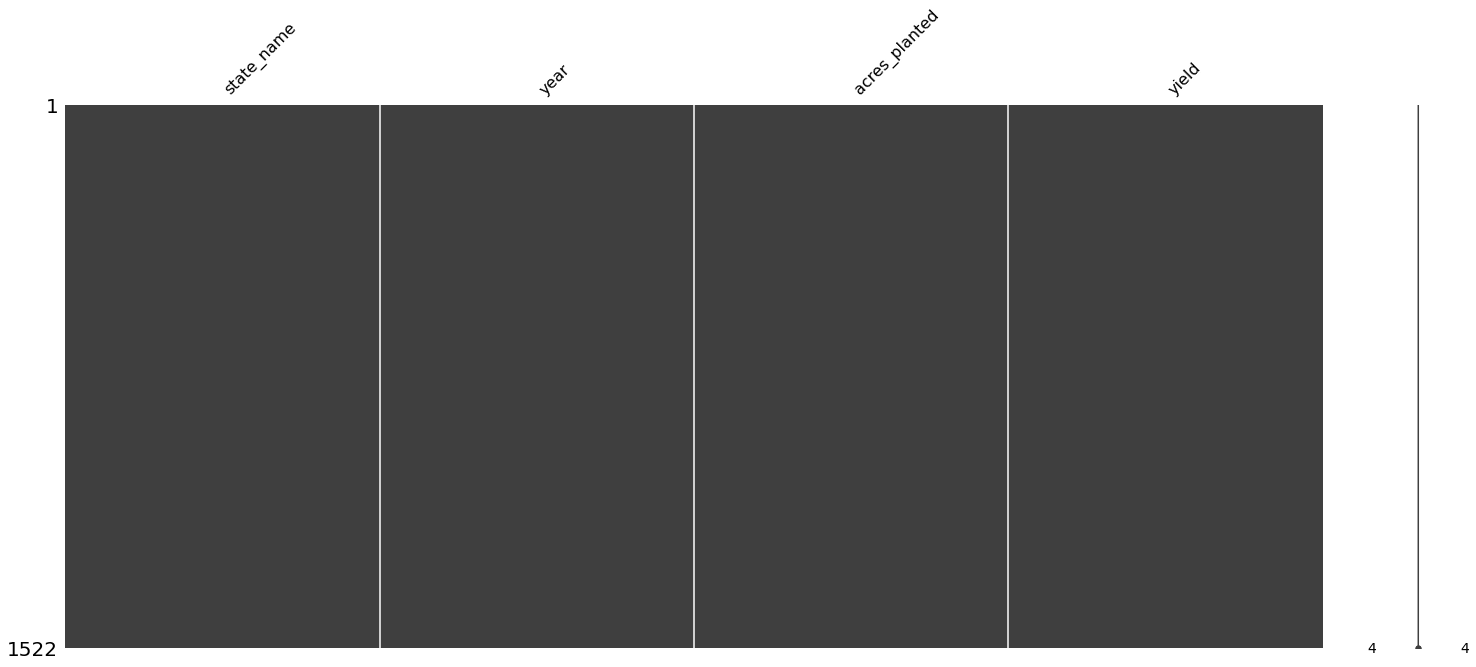

In [28]:
#checking the data
ms.matrix(nass_corn_data2);

In [29]:
nass_corn_data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1522 entries, 0 to 1813
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   state_name     1522 non-null   object
 1   year           1522 non-null   int64 
 2   acres_planted  1522 non-null   object
 3   yield          1522 non-null   object
dtypes: int64(1), object(3)
memory usage: 59.5+ KB


### Adding Information

Next a few columns need to be added for additional identifying information that will be required for the analysis. The commodity column was dropped earlier and we will add it back here. The unit of measurement was contained in the data yield point name rather than having its own column, so we will add the unit of measurement for the yield here.

In [30]:
#creating a variable for a commodity column
corn_commodity = "CORN"

In [31]:
corn_uom = "BU/ACRE"

In [32]:
#creating the commodity column
nass_corn_data2['Commodity'] = corn_commodity

In [33]:
#creating the UOM column
nass_corn_data2['UOM'] = corn_uom

In [34]:
nass_corn_data2.head()

,state_name,year,acres_planted,yield,Commodity,UOM
0,ALABAMA,1986,"340,000",57,CORN,BU/ACRE
1,ALABAMA,1987,"300,000",72,CORN,BU/ACRE
2,ALABAMA,1988,"240,000",44,CORN,BU/ACRE
3,ALABAMA,1989,"230,000",81,CORN,BU/ACRE
4,ALABAMA,1990,"290,000",58,CORN,BU/ACRE


In [35]:
nass_corn_data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1522 entries, 0 to 1813
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   state_name     1522 non-null   object
 1   year           1522 non-null   int64 
 2   acres_planted  1522 non-null   object
 3   yield          1522 non-null   object
 4   Commodity      1522 non-null   object
 5   UOM            1522 non-null   object
dtypes: int64(1), object(5)
memory usage: 83.2+ KB


# Soybean Data

The section below contains the soybean functions to request the required data from NASS

In [36]:
#run function with input parameters for AREA PLANTED
soybean_planted = ext_nass_data("A856AC67-CE95-3A48-9E4A-B69C6BDA9104", source_desc="SURVEY", sector_desc="CROPS",reference_period_desc="YEAR", short_desc="SOYBEANS - ACRES PLANTED", statisticcat_desc="AREA PLANTED", commodity_desc="SOYBEANS", agg_level_desc="STATE", year__GE=1986)

In [37]:
#Check dataframe format
soybean_planted.head()

,prodn_practice_desc,country_name,util_practice_desc,begin_code,agg_level_desc,source_desc,state_name,domain_desc,Value,statisticcat_desc,...,commodity_desc,unit_desc,region_desc,county_code,watershed_code,asd_code,zip_5,end_code,state_ansi,class_desc
0,ALL PRODUCTION PRACTICES,UNITED STATES,ALL UTILIZATION PRACTICES,00,STATE,SURVEY,OTHER STATES,TOTAL,0,AREA PLANTED,...,SOYBEANS,ACRES,,,00000000,,,00,,ALL CLASSES
1,ALL PRODUCTION PRACTICES,UNITED STATES,ALL UTILIZATION PRACTICES,00,STATE,SURVEY,OTHER STATES,TOTAL,0,AREA PLANTED,...,SOYBEANS,ACRES,,,00000000,,,00,,ALL CLASSES
2,ALL PRODUCTION PRACTICES,UNITED STATES,ALL UTILIZATION PRACTICES,00,STATE,SURVEY,OTHER STATES,TOTAL,0,AREA PLANTED,...,SOYBEANS,ACRES,,,00000000,,,00,,ALL CLASSES
3,ALL PRODUCTION PRACTICES,UNITED STATES,ALL UTILIZATION PRACTICES,00,STATE,SURVEY,OTHER STATES,TOTAL,0,AREA PLANTED,...,SOYBEANS,ACRES,,,00000000,,,00,,ALL CLASSES
4,ALL PRODUCTION PRACTICES,UNITED STATES,ALL UTILIZATION PRACTICES,00,STATE,SURVEY,OTHER STATES,TOTAL,0,AREA PLANTED,...,SOYBEANS,ACRES,,,00000000,,,00,,ALL CLASSES


In [38]:
#Check dataframe info
soybean_planted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1150 entries, 0 to 1149
Data columns (total 39 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   prodn_practice_desc    1150 non-null   object
 1   country_name           1150 non-null   object
 2   util_practice_desc     1150 non-null   object
 3   begin_code             1150 non-null   object
 4   agg_level_desc         1150 non-null   object
 5   source_desc            1150 non-null   object
 6   state_name             1150 non-null   object
 7   domain_desc            1150 non-null   object
 8   Value                  1150 non-null   object
 9   statisticcat_desc      1150 non-null   object
 10  year                   1150 non-null   int64 
 11  country_code           1150 non-null   object
 12  reference_period_desc  1150 non-null   object
 13  group_desc             1150 non-null   object
 14  freq_desc              1150 non-null   object
 15  sector_desc          

In [39]:
soybean_planted.short_desc.unique()

array(['SOYBEANS - ACRES PLANTED'], dtype=object)

### Soybean  Acres Planted Pivot

Next step is to pivot the data so we can have the SOYBEANS - ACRES PLANTED values in their own column. This is neccessary to join the later data and for better function is visualizations.

In [40]:
#pivot the dataframe
soybean_pivot1 = soybean_planted.pivot(index=["state_name", "year"], columns=["short_desc"], values=["Value"]).reset_index()

In [41]:
#check the data format
soybean_pivot1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1150 entries, 0 to 1149
Data columns (total 3 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   (state_name, )                     1150 non-null   object
 1   (year, )                           1150 non-null   int64 
 2   (Value, SOYBEANS - ACRES PLANTED)  1150 non-null   object
dtypes: int64(1), object(2)
memory usage: 27.1+ KB


###  Flatten the Index

In [42]:
#flattening the index
soybean_pivot1.columns = ["_".join(tup) for tup in soybean_pivot1.columns.to_flat_index()]
soybean_pivot1.reset_index()

,index,state_name_,year_,Value_SOYBEANS - ACRES PLANTED
0,0,ALABAMA,1986,"650,000"
1,1,ALABAMA,1987,"600,000"
2,2,ALABAMA,1988,"590,000"
3,3,ALABAMA,1989,"600,000"
4,4,ALABAMA,1990,"470,000"
...,...,...,...,...
1145,1145,WISCONSIN,2019,"1,750,000"
1146,1146,WISCONSIN,2020,"2,020,000"
1147,1147,WISCONSIN,2021,"2,100,000"
1148,1148,WISCONSIN,2022,"2,160,000"


In [43]:
#Renaming columns 
soybean_pivot1 = soybean_pivot1.rename(columns={"state_name_": "state_name", "year_": "year", "Value_SOYBEANS - ACRES PLANTED": "acres_planted"})

In [44]:
soybean_pivot1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1150 entries, 0 to 1149
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   state_name     1150 non-null   object
 1   year           1150 non-null   int64 
 2   acres_planted  1150 non-null   object
dtypes: int64(1), object(2)
memory usage: 27.1+ KB


### Yield Request

This section will request theld dat for the soybean commodity.

In [45]:
#run function with input parameters for YIELD
soybean_yield = ext_nass_data("A856AC67-CE95-3A48-9E4A-B69C6BDA9104", source_desc="SURVEY", sector_desc="CROPS", reference_period_desc="YEAR", short_desc="SOYBEANS - YIELD, MEASURED IN BU / ACRE", statisticcat_desc="YIELD", commodity_desc="SOYBEANS", agg_level_desc="STATE", year__GE=1986)

In [46]:
#Check dataframe format
soybean_yield.head()

,sector_desc,county_name,state_fips_code,Value,load_time,county_code,asd_desc,state_name,domaincat_desc,congr_district_code,...,year,agg_level_desc,CV (%),statisticcat_desc,country_code,class_desc,watershed_code,group_desc,short_desc,prodn_practice_desc
0,CROPS,,98,0,2019-09-30 12:00:28.000,,,OTHER STATES,NOT SPECIFIED,,...,2018,STATE,,YIELD,9000,ALL CLASSES,00000000,FIELD CROPS,"SOYBEANS - YIELD, MEASURED IN BU / ACRE",ALL PRODUCTION PRACTICES
1,CROPS,,98,0,2018-09-28 12:01:19.000,,,OTHER STATES,NOT SPECIFIED,,...,2017,STATE,,YIELD,9000,ALL CLASSES,00000000,FIELD CROPS,"SOYBEANS - YIELD, MEASURED IN BU / ACRE",ALL PRODUCTION PRACTICES
2,CROPS,,98,0,2017-01-12 12:05:05.000,,,OTHER STATES,NOT SPECIFIED,,...,2016,STATE,,YIELD,9000,ALL CLASSES,00000000,FIELD CROPS,"SOYBEANS - YIELD, MEASURED IN BU / ACRE",ALL PRODUCTION PRACTICES
3,CROPS,,98,0,2016-09-30 12:00:00.000,,,OTHER STATES,NOT SPECIFIED,,...,2015,STATE,,YIELD,9000,ALL CLASSES,00000000,FIELD CROPS,"SOYBEANS - YIELD, MEASURED IN BU / ACRE",ALL PRODUCTION PRACTICES
4,CROPS,,01,41,2023-01-12 12:00:00.000,,,ALABAMA,NOT SPECIFIED,,...,2022,STATE,,YIELD,9000,ALL CLASSES,00000000,FIELD CROPS,"SOYBEANS - YIELD, MEASURED IN BU / ACRE",ALL PRODUCTION PRACTICES


In [47]:
#Check dataframe info
soybean_yield.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1117 entries, 0 to 1116
Data columns (total 39 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   sector_desc            1117 non-null   object
 1   county_name            1117 non-null   object
 2   state_fips_code        1117 non-null   object
 3   Value                  1117 non-null   object
 4   load_time              1117 non-null   object
 5   county_code            1117 non-null   object
 6   asd_desc               1117 non-null   object
 7   state_name             1117 non-null   object
 8   domaincat_desc         1117 non-null   object
 9   congr_district_code    1117 non-null   object
 10  week_ending            1117 non-null   object
 11  util_practice_desc     1117 non-null   object
 12  domain_desc            1117 non-null   object
 13  state_ansi             1117 non-null   object
 14  state_alpha            1117 non-null   object
 15  country_name         

### Soybean Yield Pivot

Next step is to pivot the data so we can have the SOYBEANS - YIELD values in their own column. This is neccessary to join the later data and for better function is visualizations.

In [48]:
#pivot the dataframe
soybean_pivot2 = soybean_yield.pivot(index=["state_name", "year"], columns=["short_desc"], values=["Value"]).reset_index()

In [49]:
soybean_pivot2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1117 entries, 0 to 1116
Data columns (total 3 columns):
 #   Column                                            Non-Null Count  Dtype 
---  ------                                            --------------  ----- 
 0   (state_name, )                                    1117 non-null   object
 1   (year, )                                          1117 non-null   int64 
 2   (Value, SOYBEANS - YIELD, MEASURED IN BU / ACRE)  1117 non-null   object
dtypes: int64(1), object(2)
memory usage: 26.3+ KB


### Flatten the Index

After the pivot, a multi-level index was created. Next we will flatten the index and rename the columns.

In [50]:
#flattening the index
soybean_pivot2.columns = ["_".join(tup) for tup in soybean_pivot2.columns.to_flat_index()]
soybean_pivot2.reset_index()

,index,state_name_,year_,"Value_SOYBEANS - YIELD, MEASURED IN BU / ACRE"
0,0,ALABAMA,1986,23
1,1,ALABAMA,1987,18
2,2,ALABAMA,1988,25
3,3,ALABAMA,1989,21
4,4,ALABAMA,1990,17
...,...,...,...,...
1112,1112,WISCONSIN,2018,48
1113,1113,WISCONSIN,2019,47
1114,1114,WISCONSIN,2020,52
1115,1115,WISCONSIN,2021,55


In [51]:
#Renaming columns 
soybean_pivot2 = soybean_pivot2.rename(columns={"state_name_": "state_name", "year_": "year", "Value_SOYBEANS - YIELD, MEASURED IN BU / ACRE": "yield"})

In [52]:
soybean_pivot2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1117 entries, 0 to 1116
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   state_name  1117 non-null   object
 1   year        1117 non-null   int64 
 2   yield       1117 non-null   object
dtypes: int64(1), object(2)
memory usage: 26.3+ KB


In [53]:
#combine the soy_yield and soy_planted dataframes into one
nass_soybean_data1 =  pd.merge(soybean_pivot1, soybean_pivot2, on =["year", "state_name"], how ='outer')

In [54]:
nass_soybean_data1.head()

,state_name,year,acres_planted,yield
0,ALABAMA,1986,"650,000",23
1,ALABAMA,1987,"600,000",18
2,ALABAMA,1988,"590,000",25
3,ALABAMA,1989,"600,000",21
4,ALABAMA,1990,"470,000",17


In [55]:
nass_soybean_data1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1150 entries, 0 to 1149
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   state_name     1150 non-null   object
 1   year           1150 non-null   int64 
 2   acres_planted  1150 non-null   object
 3   yield          1117 non-null   object
dtypes: int64(1), object(3)
memory usage: 44.9+ KB


## Missing Data

Next we will work to identify missing data.

In [56]:
is_nan2 = nass_soybean_data1[nass_soybean_data1.isnull().any(axis=1)]
print(is_nan2)

          state_name  year acres_planted yield
37           ALABAMA  2023       400,000   NaN
75          ARKANSAS  2023     2,900,000   NaN
113         DELAWARE  2023       150,000   NaN
184          GEORGIA  2023       170,000   NaN
222         ILLINOIS  2023    10,000,000   NaN
260          INDIANA  2023     5,500,000   NaN
298             IOWA  2023     9,700,000   NaN
336           KANSAS  2023     4,250,000   NaN
374         KENTUCKY  2023     1,900,000   NaN
412        LOUISIANA  2023     1,120,000   NaN
450         MARYLAND  2023       490,000   NaN
488         MICHIGAN  2023     2,050,000   NaN
526        MINNESOTA  2023     7,500,000   NaN
564      MISSISSIPPI  2023     2,300,000   NaN
602         MISSOURI  2023     5,600,000   NaN
640         NEBRASKA  2023     5,500,000   NaN
678       NEW JERSEY  2023       110,000   NaN
704         NEW YORK  2023       355,000   NaN
742   NORTH CAROLINA  2023     1,650,000   NaN
780     NORTH DAKOTA  2023     5,650,000   NaN
818          

In [57]:
yield_missing = nass_soybean_data1[nass_soybean_data1.isnull().any(axis=1)]
missing_sum = yield_missing["state_name"].value_counts()
print(missing_sum)

OTHER STATES      4
KANSAS            1
TEXAS             1
IOWA              1
MINNESOTA         1
VIRGINIA          1
WISCONSIN         1
GEORGIA           1
MISSOURI          1
TENNESSEE         1
PENNSYLVANIA      1
ALABAMA           1
ARKANSAS          1
MISSISSIPPI       1
NORTH DAKOTA      1
OKLAHOMA          1
MICHIGAN          1
ILLINOIS          1
INDIANA           1
DELAWARE          1
SOUTH DAKOTA      1
SOUTH CAROLINA    1
NEBRASKA          1
OHIO              1
NEW YORK          1
NORTH CAROLINA    1
LOUISIANA         1
KENTUCKY          1
MARYLAND          1
NEW JERSEY        1
Name: state_name, dtype: int64


In [58]:
yield_year_missing = nass_soybean_data1[nass_soybean_data1.isnull().any(axis=1)]
missing_year_sum = yield_year_missing["year"].value_counts()
print(missing_year_sum)

2023    30
2019     1
2020     1
2021     1
Name: year, dtype: int64


### Investigation

The missing data comes from the year 2023 for all states, and a few others missing for the "Other states" category. This data is not relevant to the analysis so I will drop these missing values from the soy dataframe.

In [59]:
#dropping the missing values
nass_soybean_data2 = nass_soybean_data1.dropna()

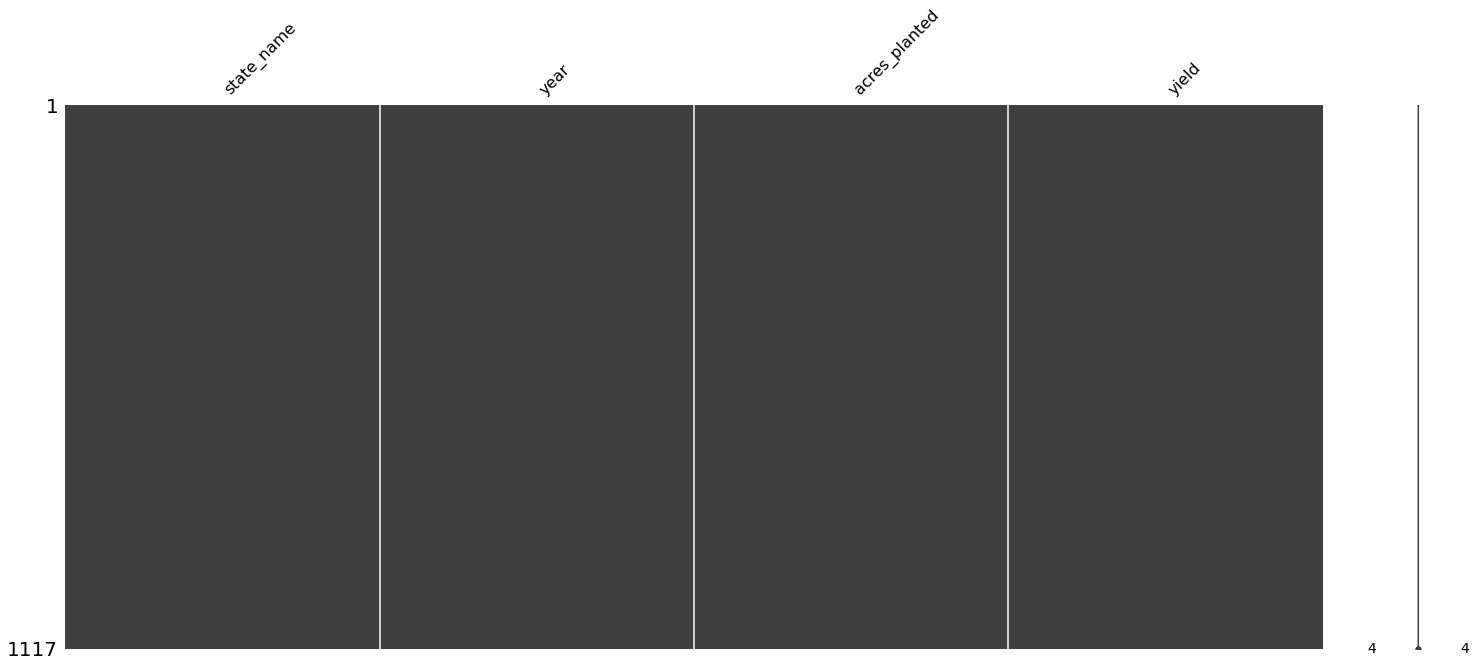

In [60]:
#checking the data
ms.matrix(nass_soybean_data2);

In [61]:
nass_soybean_data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1117 entries, 0 to 1148
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   state_name     1117 non-null   object
 1   year           1117 non-null   int64 
 2   acres_planted  1117 non-null   object
 3   yield          1117 non-null   object
dtypes: int64(1), object(3)
memory usage: 43.6+ KB


In [62]:
#creating a variable for a commodity column
soy_commodity = "SOYBEAN"

In [63]:
#creating a variable for UOM
soy_uom = "BU/ACRE"

In [64]:
#creating the commodity column
nass_soybean_data2['Commodity'] = soy_commodity

In [65]:
#creating the UOM column
nass_soybean_data2['UOM'] = soy_uom

In [66]:
nass_soybean_data2.head()

,state_name,year,acres_planted,yield,Commodity,UOM
0,ALABAMA,1986,"650,000",23,SOYBEAN,BU/ACRE
1,ALABAMA,1987,"600,000",18,SOYBEAN,BU/ACRE
2,ALABAMA,1988,"590,000",25,SOYBEAN,BU/ACRE
3,ALABAMA,1989,"600,000",21,SOYBEAN,BU/ACRE
4,ALABAMA,1990,"470,000",17,SOYBEAN,BU/ACRE


In [67]:
nass_soybean_data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1117 entries, 0 to 1148
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   state_name     1117 non-null   object
 1   year           1117 non-null   int64 
 2   acres_planted  1117 non-null   object
 3   yield          1117 non-null   object
 4   Commodity      1117 non-null   object
 5   UOM            1117 non-null   object
dtypes: int64(1), object(5)
memory usage: 61.1+ KB


In [68]:
nass_soybean_data2.state_name.unique()

array(['ALABAMA', 'ARKANSAS', 'DELAWARE', 'FLORIDA', 'GEORGIA',
       'ILLINOIS', 'INDIANA', 'IOWA', 'KANSAS', 'KENTUCKY', 'LOUISIANA',
       'MARYLAND', 'MICHIGAN', 'MINNESOTA', 'MISSISSIPPI', 'MISSOURI',
       'NEBRASKA', 'NEW JERSEY', 'NEW YORK', 'NORTH CAROLINA',
       'NORTH DAKOTA', 'OHIO', 'OKLAHOMA', 'OTHER STATES', 'PENNSYLVANIA',
       'SOUTH CAROLINA', 'SOUTH DAKOTA', 'TENNESSEE', 'TEXAS', 'VIRGINIA',
       'WEST VIRGINIA', 'WISCONSIN'], dtype=object)

# Cotton Data

Next we will extract the cotton data

In [69]:
#run function with input parameters
cotton_planted = ext_nass_data("A856AC67-CE95-3A48-9E4A-B69C6BDA9104", source_desc="SURVEY", sector_desc="CROPS",reference_period_desc="YEAR", short_desc="COTTON, UPLAND - ACRES PLANTED",statisticcat_desc="AREA PLANTED", commodity_desc="COTTON", agg_level_desc="STATE", year__GE=1986)

In [70]:
#Check format is correct
cotton_planted.head()

,freq_desc,begin_code,location_desc,unit_desc,watershed_desc,end_code,region_desc,commodity_desc,source_desc,zip_5,...,county_name,sector_desc,state_ansi,state_alpha,util_practice_desc,domain_desc,congr_district_code,domaincat_desc,week_ending,state_name
0,ANNUAL,00,ALABAMA,ACRES,,00,,COTTON,SURVEY,,...,,CROPS,01,AL,ALL UTILIZATION PRACTICES,TOTAL,,NOT SPECIFIED,,ALABAMA
1,ANNUAL,00,ALABAMA,ACRES,,00,,COTTON,SURVEY,,...,,CROPS,01,AL,ALL UTILIZATION PRACTICES,TOTAL,,NOT SPECIFIED,,ALABAMA
2,ANNUAL,00,ALABAMA,ACRES,,00,,COTTON,SURVEY,,...,,CROPS,01,AL,ALL UTILIZATION PRACTICES,TOTAL,,NOT SPECIFIED,,ALABAMA
3,ANNUAL,00,ALABAMA,ACRES,,00,,COTTON,SURVEY,,...,,CROPS,01,AL,ALL UTILIZATION PRACTICES,TOTAL,,NOT SPECIFIED,,ALABAMA
4,ANNUAL,00,ALABAMA,ACRES,,00,,COTTON,SURVEY,,...,,CROPS,01,AL,ALL UTILIZATION PRACTICES,TOTAL,,NOT SPECIFIED,,ALABAMA


In [71]:
#Check info on dataframe
cotton_planted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 646 entries, 0 to 645
Data columns (total 39 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   freq_desc              646 non-null    object
 1   begin_code             646 non-null    object
 2   location_desc          646 non-null    object
 3   unit_desc              646 non-null    object
 4   watershed_desc         646 non-null    object
 5   end_code               646 non-null    object
 6   region_desc            646 non-null    object
 7   commodity_desc         646 non-null    object
 8   source_desc            646 non-null    object
 9   zip_5                  646 non-null    object
 10  county_ansi            646 non-null    object
 11  reference_period_desc  646 non-null    object
 12  country_name           646 non-null    object
 13  asd_code               646 non-null    object
 14  short_desc             646 non-null    object
 15  prodn_practice_desc    

In [72]:
cotton_planted.short_desc.unique()

array(['COTTON, UPLAND - ACRES PLANTED'], dtype=object)

### Cotton Acres Planted Pivot

Next step is to pivot the data so we can have the COTTON, UPLAND - ACRES PLANTED values in their own column. This is neccessary to join the later data and for better function is visualizations.

In [73]:
#pivot the dataframe
cotton_pivot1 = cotton_planted.pivot(index=["state_name", "year"], columns=["short_desc"], values=["Value"]).reset_index()

In [74]:
#checking the output
cotton_pivot1.info

<bound method DataFrame.info of            state_name  year                          Value
short_desc                  COTTON, UPLAND - ACRES PLANTED
0             ALABAMA  1986                        315,000
1             ALABAMA  1987                        335,000
2             ALABAMA  1988                        390,000
3             ALABAMA  1989                        328,000
4             ALABAMA  1990                        380,000
..                ...   ...                            ...
641          VIRGINIA  2019                        103,000
642          VIRGINIA  2020                         80,000
643          VIRGINIA  2021                         75,000
644          VIRGINIA  2022                         91,000
645          VIRGINIA  2023                         85,000

[646 rows x 3 columns]>

### Flatten the Index

After the pivot, a multi-level index was created. Next we will flatten the index and rename the columns.

In [75]:
#flattening the index
cotton_pivot1.columns = ["_".join(tup) for tup in cotton_pivot1.columns.to_flat_index()]
cotton_pivot1.reset_index()

,index,state_name_,year_,"Value_COTTON, UPLAND - ACRES PLANTED"
0,0,ALABAMA,1986,"315,000"
1,1,ALABAMA,1987,"335,000"
2,2,ALABAMA,1988,"390,000"
3,3,ALABAMA,1989,"328,000"
4,4,ALABAMA,1990,"380,000"
...,...,...,...,...
641,641,VIRGINIA,2019,"103,000"
642,642,VIRGINIA,2020,"80,000"
643,643,VIRGINIA,2021,"75,000"
644,644,VIRGINIA,2022,"91,000"


In [76]:
#Renaming columns 
cotton_pivot1 = cotton_pivot1.rename(columns={"state_name_": "state_name", "year_": "year", "Value_COTTON, UPLAND - ACRES PLANTED": "acres_planted"})

In [77]:
cotton_pivot1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 646 entries, 0 to 645
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   state_name     646 non-null    object
 1   year           646 non-null    int64 
 2   acres_planted  646 non-null    object
dtypes: int64(1), object(2)
memory usage: 15.3+ KB


### Yield Request

The below function creates the request for the YIELD category data items from NASS.

In [78]:
#Run function with input parameters
cotton_yield = ext_nass_data("A856AC67-CE95-3A48-9E4A-B69C6BDA9104", source_desc="SURVEY", sector_desc="CROPS",reference_period_desc="YEAR", short_desc="COTTON, UPLAND - YIELD, MEASURED IN LB / ACRE",statisticcat_desc="YIELD", commodity_desc="COTTON", agg_level_desc="STATE", year__GE=1986)

In [79]:
#Check dataframe format
cotton_yield.head()

,location_desc,CV (%),congr_district_code,county_name,short_desc,state_alpha,state_fips_code,week_ending,domaincat_desc,load_time,...,asd_desc,group_desc,reference_period_desc,watershed_desc,freq_desc,sector_desc,country_code,year,statisticcat_desc,Value
0,ALABAMA,,,,"COTTON, UPLAND - YIELD, MEASURED IN LB / ACRE",AL,01,,NOT SPECIFIED,2023-05-12 12:00:00.000,...,,FIELD CROPS,YEAR,,ANNUAL,CROPS,9000,2022,YIELD,930
1,ALABAMA,,,,"COTTON, UPLAND - YIELD, MEASURED IN LB / ACRE",AL,01,,NOT SPECIFIED,2023-05-12 12:00:00.000,...,,FIELD CROPS,YEAR,,ANNUAL,CROPS,9000,2021,YIELD,826
2,ALABAMA,,,,"COTTON, UPLAND - YIELD, MEASURED IN LB / ACRE",AL,01,,NOT SPECIFIED,2022-05-12 12:00:26.000,...,,FIELD CROPS,YEAR,,ANNUAL,CROPS,9000,2020,YIELD,790
3,ALABAMA,,,,"COTTON, UPLAND - YIELD, MEASURED IN LB / ACRE",AL,01,,NOT SPECIFIED,2021-05-12 12:01:31.000,...,,FIELD CROPS,YEAR,,ANNUAL,CROPS,9000,2019,YIELD,928
4,ALABAMA,,,,"COTTON, UPLAND - YIELD, MEASURED IN LB / ACRE",AL,01,,NOT SPECIFIED,2020-05-12 15:00:30.000,...,,FIELD CROPS,YEAR,,ANNUAL,CROPS,9000,2018,YIELD,863


In [80]:
#Check dataframe info
cotton_yield.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 39 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   location_desc          629 non-null    object
 1   CV (%)                 629 non-null    object
 2   congr_district_code    629 non-null    object
 3   county_name            629 non-null    object
 4   short_desc             629 non-null    object
 5   state_alpha            629 non-null    object
 6   state_fips_code        629 non-null    object
 7   week_ending            629 non-null    object
 8   domaincat_desc         629 non-null    object
 9   load_time              629 non-null    object
 10  county_ansi            629 non-null    object
 11  class_desc             629 non-null    object
 12  end_code               629 non-null    object
 13  state_ansi             629 non-null    object
 14  asd_code               629 non-null    object
 15  zip_5                  

In [81]:
cotton_yield.short_desc.unique()

array(['COTTON, UPLAND - YIELD, MEASURED IN LB / ACRE'], dtype=object)

### Cotton Yield Pivot

Next step is to pivot the data so we can have the COTTON, UPLAND - YIELD values in their own column. This is neccessary to join the later data and for better function is visualizations.

In [82]:
#pivot the dataframe
cotton_pivot2 = cotton_yield.pivot(index=["state_name", "year"], columns=["short_desc"], values=["Value"]).reset_index()

In [83]:
#check the dataframe
cotton_pivot2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 3 columns):
 #   Column                                                  Non-Null Count  Dtype 
---  ------                                                  --------------  ----- 
 0   (state_name, )                                          629 non-null    object
 1   (year, )                                                629 non-null    int64 
 2   (Value, COTTON, UPLAND - YIELD, MEASURED IN LB / ACRE)  629 non-null    object
dtypes: int64(1), object(2)
memory usage: 14.9+ KB


### Flatten the Index

After the pivot, a multi-level index was created. Next we will flatten the index and rename the columns.

In [84]:
#flattening the index
cotton_pivot2.columns = ["_".join(tup) for tup in cotton_pivot2.columns.to_flat_index()]
cotton_pivot2.reset_index()

,index,state_name_,year_,"Value_COTTON, UPLAND - YIELD, MEASURED IN LB / ACRE"
0,0,ALABAMA,1986,506
1,1,ALABAMA,1987,572
2,2,ALABAMA,1988,486
3,3,ALABAMA,1989,571
4,4,ALABAMA,1990,476
...,...,...,...,...
624,624,VIRGINIA,2018,896
625,625,VIRGINIA,2019,"1,144"
626,626,VIRGINIA,2020,772
627,627,VIRGINIA,2021,"1,109"


In [85]:
#Renaming columns 
cotton_pivot2 = cotton_pivot2.rename(columns={"state_name_": "state_name", "year_": "year", "Value_COTTON, UPLAND - YIELD, MEASURED IN LB / ACRE": "yield"})

In [86]:
cotton_pivot2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   state_name  629 non-null    object
 1   year        629 non-null    int64 
 2   yield       629 non-null    object
dtypes: int64(1), object(2)
memory usage: 14.9+ KB


In [87]:
#combine the cotton_yield and cotton_acres_planted dataframes into one
nass_cotton_data1 =  pd.merge(cotton_pivot1, cotton_pivot2, on =["year", "state_name"], how ='outer')

In [88]:
nass_cotton_data1.head()

,state_name,year,acres_planted,yield
0,ALABAMA,1986,"315,000",506
1,ALABAMA,1987,"335,000",572
2,ALABAMA,1988,"390,000",486
3,ALABAMA,1989,"328,000",571
4,ALABAMA,1990,"380,000",476


In [89]:
nass_cotton_data1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 646 entries, 0 to 645
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   state_name     646 non-null    object
 1   year           646 non-null    int64 
 2   acres_planted  646 non-null    object
 3   yield          629 non-null    object
dtypes: int64(1), object(3)
memory usage: 25.2+ KB


In [90]:
is_nan2 = nass_cotton_data1[nass_cotton_data1.isnull().any(axis=1)]
print(is_nan2)

         state_name  year acres_planted yield
37          ALABAMA  2023       380,000   NaN
75          ARIZONA  2023        75,000   NaN
113        ARKANSAS  2023       480,000   NaN
151      CALIFORNIA  2023        13,000   NaN
189         FLORIDA  2023        90,000   NaN
227         GEORGIA  2023     1,200,000   NaN
265          KANSAS  2023       170,000   NaN
303       LOUISIANA  2023       130,000   NaN
341     MISSISSIPPI  2023       380,000   NaN
379        MISSOURI  2023       350,000   NaN
417      NEW MEXICO  2023        35,000   NaN
455  NORTH CAROLINA  2023       380,000   NaN
493        OKLAHOMA  2023       570,000   NaN
531  SOUTH CAROLINA  2023       230,000   NaN
569       TENNESSEE  2023       310,000   NaN
607           TEXAS  2023     6,100,000   NaN
645        VIRGINIA  2023        85,000   NaN


In [91]:
yield_missing = nass_cotton_data1[nass_cotton_data1.isnull().any(axis=1)]
missing_sum = yield_missing["state_name"].value_counts()
print(missing_sum)

KANSAS            1
NORTH CAROLINA    1
ARIZONA           1
ALABAMA           1
OKLAHOMA          1
VIRGINIA          1
MISSISSIPPI       1
NEW MEXICO        1
GEORGIA           1
ARKANSAS          1
MISSOURI          1
TENNESSEE         1
LOUISIANA         1
FLORIDA           1
CALIFORNIA        1
TEXAS             1
SOUTH CAROLINA    1
Name: state_name, dtype: int64


In [92]:
yield_year_missing = nass_cotton_data1[nass_cotton_data1.isnull().any(axis=1)]
missing_year_sum = yield_year_missing["year"].value_counts()
print(missing_year_sum)

2023    17
Name: year, dtype: int64


### Investigation

The missing data comes from the year 2023 for all states, and a few others missing for the "Other states" category. This data is not relevant to the analysis so I will drop these missing values from the soy dataframe.

In [93]:
#dropping the missing values
nass_cotton_data2 = nass_cotton_data1.dropna()

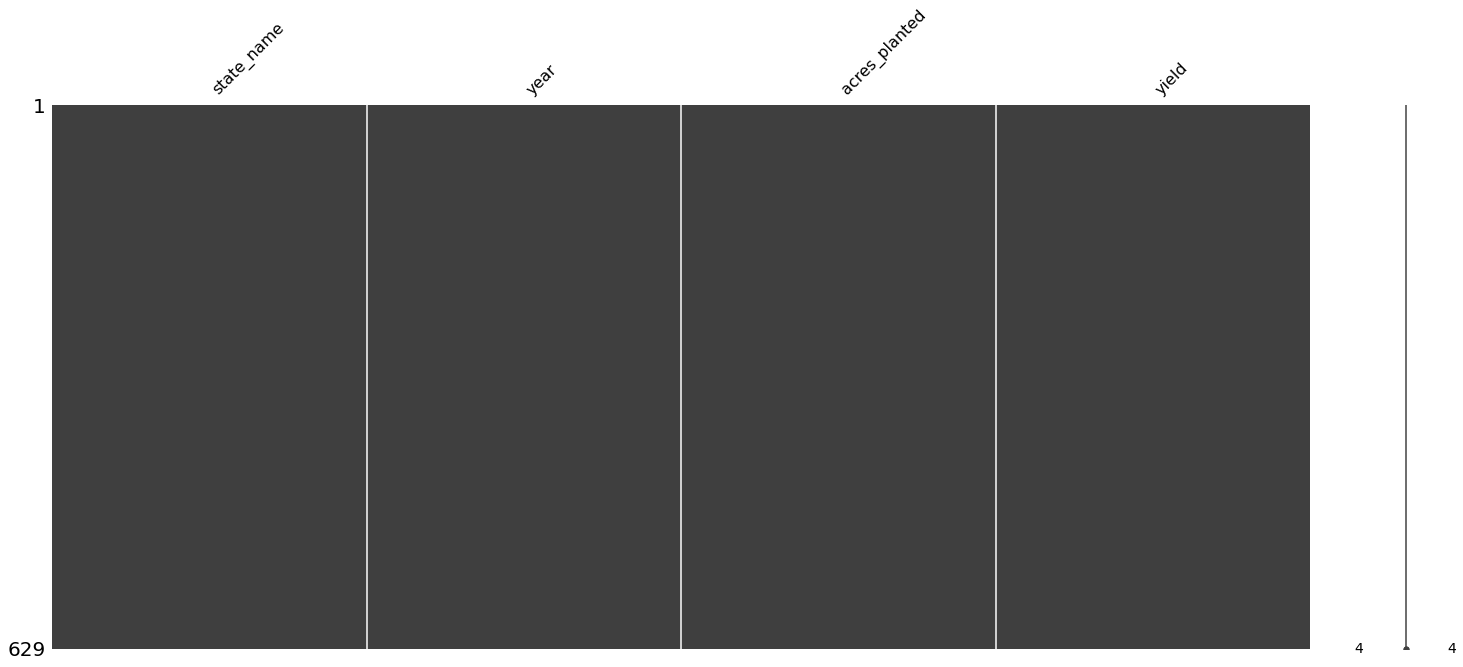

In [94]:
#checking the data
ms.matrix(nass_cotton_data2);

In [95]:
nass_cotton_data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 629 entries, 0 to 644
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   state_name     629 non-null    object
 1   year           629 non-null    int64 
 2   acres_planted  629 non-null    object
 3   yield          629 non-null    object
dtypes: int64(1), object(3)
memory usage: 24.6+ KB


In [96]:
#creating a variable for a commodity column
cotton_commodity = "COTTON"

In [97]:
cotton_uom = "LB/ACRE"

In [98]:
#creating the commodity column
nass_cotton_data2['Commodity'] = cotton_commodity

In [99]:
#creating the UOM column
nass_cotton_data2['UOM'] = cotton_uom

In [100]:
nass_cotton_data2.head()

,state_name,year,acres_planted,yield,Commodity,UOM
0,ALABAMA,1986,"315,000",506,COTTON,LB/ACRE
1,ALABAMA,1987,"335,000",572,COTTON,LB/ACRE
2,ALABAMA,1988,"390,000",486,COTTON,LB/ACRE
3,ALABAMA,1989,"328,000",571,COTTON,LB/ACRE
4,ALABAMA,1990,"380,000",476,COTTON,LB/ACRE


In [101]:
nass_cotton_data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 629 entries, 0 to 644
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   state_name     629 non-null    object
 1   year           629 non-null    int64 
 2   acres_planted  629 non-null    object
 3   yield          629 non-null    object
 4   Commodity      629 non-null    object
 5   UOM            629 non-null    object
dtypes: int64(1), object(5)
memory usage: 34.4+ KB


# Combine Data

Below we will merge our datasets from corn, soybean and cotton to create a single row crop dataframe. In this stage we need to join this dataframe with the biotech (GE) data for all of the crops. 

In [102]:
#combine the dataframes
nass_rowcrop_data = pd.concat([nass_corn_data2, nass_soybean_data2, nass_cotton_data2], ignore_index=True)

In [103]:
#check the dataframe format
nass_rowcrop_data.head()

,state_name,year,acres_planted,yield,Commodity,UOM
0,ALABAMA,1986,"340,000",57,CORN,BU/ACRE
1,ALABAMA,1987,"300,000",72,CORN,BU/ACRE
2,ALABAMA,1988,"240,000",44,CORN,BU/ACRE
3,ALABAMA,1989,"230,000",81,CORN,BU/ACRE
4,ALABAMA,1990,"290,000",58,CORN,BU/ACRE


In [104]:
#check the dataframe info
nass_rowcrop_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3268 entries, 0 to 3267
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   state_name     3268 non-null   object
 1   year           3268 non-null   int64 
 2   acres_planted  3268 non-null   object
 3   yield          3268 non-null   object
 4   Commodity      3268 non-null   object
 5   UOM            3268 non-null   object
dtypes: int64(1), object(5)
memory usage: 153.3+ KB


In [105]:
#checking that all commodities are in the dataframe
nass_rowcrop_data.Commodity.unique()

array(['CORN', 'SOYBEAN', 'COTTON'], dtype=object)

In [106]:
nass_rowcrop_data.state_name.unique()

array(['ALABAMA', 'ARIZONA', 'ARKANSAS', 'CALIFORNIA', 'COLORADO',
       'DELAWARE', 'FLORIDA', 'GEORGIA', 'IDAHO', 'ILLINOIS', 'INDIANA',
       'IOWA', 'KANSAS', 'KENTUCKY', 'LOUISIANA', 'MARYLAND', 'MICHIGAN',
       'MINNESOTA', 'MISSISSIPPI', 'MISSOURI', 'MONTANA', 'NEBRASKA',
       'NEW JERSEY', 'NEW MEXICO', 'NEW YORK', 'NORTH CAROLINA',
       'NORTH DAKOTA', 'OHIO', 'OKLAHOMA', 'OREGON', 'OTHER STATES',
       'PENNSYLVANIA', 'SOUTH CAROLINA', 'SOUTH DAKOTA', 'TENNESSEE',
       'TEXAS', 'UTAH', 'VIRGINIA', 'WASHINGTON', 'WEST VIRGINIA',
       'WISCONSIN', 'WYOMING'], dtype=object)

"Other States" has been included in the data extract, these will be removed as they are not relevant to the analysis.

In [107]:
#dropping "other states"
nass_rowcrop_data = nass_rowcrop_data.drop(nass_rowcrop_data[nass_rowcrop_data.state_name == "OTHER STATES"].index)

In [108]:
#checking the unique states
nass_rowcrop_data.state_name.unique()

array(['ALABAMA', 'ARIZONA', 'ARKANSAS', 'CALIFORNIA', 'COLORADO',
       'DELAWARE', 'FLORIDA', 'GEORGIA', 'IDAHO', 'ILLINOIS', 'INDIANA',
       'IOWA', 'KANSAS', 'KENTUCKY', 'LOUISIANA', 'MARYLAND', 'MICHIGAN',
       'MINNESOTA', 'MISSISSIPPI', 'MISSOURI', 'MONTANA', 'NEBRASKA',
       'NEW JERSEY', 'NEW MEXICO', 'NEW YORK', 'NORTH CAROLINA',
       'NORTH DAKOTA', 'OHIO', 'OKLAHOMA', 'OREGON', 'PENNSYLVANIA',
       'SOUTH CAROLINA', 'SOUTH DAKOTA', 'TENNESSEE', 'TEXAS', 'UTAH',
       'VIRGINIA', 'WASHINGTON', 'WEST VIRGINIA', 'WISCONSIN', 'WYOMING'],
      dtype=object)

In [109]:
#checking for duplicates
dups = nass_rowcrop_data.duplicated(subset=['year', 'state_name', 'Commodity'])

In [110]:
#dropping duplicates
nass_rowcrop_data.drop_duplicates(subset=['year', 'state_name', 'Commodity'], keep='first')

,state_name,year,acres_planted,yield,Commodity,UOM
0,ALABAMA,1986,"340,000",57,CORN,BU/ACRE
1,ALABAMA,1987,"300,000",72,CORN,BU/ACRE
2,ALABAMA,1988,"240,000",44,CORN,BU/ACRE
3,ALABAMA,1989,"230,000",81,CORN,BU/ACRE
4,ALABAMA,1990,"290,000",58,CORN,BU/ACRE
...,...,...,...,...,...,...
3263,VIRGINIA,2018,"98,000",896,COTTON,LB/ACRE
3264,VIRGINIA,2019,"103,000","1,144",COTTON,LB/ACRE
3265,VIRGINIA,2020,"80,000",772,COTTON,LB/ACRE
3266,VIRGINIA,2021,"75,000","1,109",COTTON,LB/ACRE


In [111]:
nass_rowcrop_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3259 entries, 0 to 3267
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   state_name     3259 non-null   object
 1   year           3259 non-null   int64 
 2   acres_planted  3259 non-null   object
 3   yield          3259 non-null   object
 4   Commodity      3259 non-null   object
 5   UOM            3259 non-null   object
dtypes: int64(1), object(5)
memory usage: 178.2+ KB


## Genetically Engineered Seed Data Import and Merge

The data for percentages of crop planted that are GE type is available comes from a seperate source as NASS does not have all available years - only through 2014. The USDA Economic Research Service provides a cvs format of "Adoption of Genetically Engineered Crops in The US" that have data starting from 2000. This data provides a percentage planted each year for each state.

I will join this data with our combined NASS dataframes to create new columns for our final dataset. We will be able to create the acres planted by GE percentage planted which will give us an acreage number for acres of GE planted.

In [112]:
#Bringing in the ge planted csv
biotech_data = pd.read_csv("GE Planted.csv")

In [113]:
#checking the data
biotech_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 910 entries, 0 to 909
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Attribute       910 non-null    object
 1   year            910 non-null    int64 
 2   state_name      910 non-null    object
 3   Ge_Pct_Planted  910 non-null    int64 
 4   Table           910 non-null    object
 5   Commodity       910 non-null    object
dtypes: int64(2), object(4)
memory usage: 42.8+ KB


In [114]:
#checking the data format
biotech_data.head()

,Attribute,year,state_name,Ge_Pct_Planted,Table,Commodity
0,All GE varieties (percent of all corn planted),2000,ILLINOIS,17,Genetically engineered (GE) corn varieties,CORN
1,All GE varieties (percent of all corn planted),2001,ILLINOIS,16,Genetically engineered (GE) corn varieties,CORN
2,All GE varieties (percent of all corn planted),2002,ILLINOIS,22,Genetically engineered (GE) corn varieties,CORN
3,All GE varieties (percent of all corn planted),2003,ILLINOIS,28,Genetically engineered (GE) corn varieties,CORN
4,All GE varieties (percent of all corn planted),2004,ILLINOIS,33,Genetically engineered (GE) corn varieties,CORN


In [115]:
#checking the commodity
biotech_data['Commodity'].unique()

array(['CORN', 'SOYBEAN', 'COTTON'], dtype=object)

In [116]:
#dropping the irrelevant tables
biotech_data = biotech_data.drop(columns=['Table', 'Attribute'])

In [117]:
#merging the dataframes
biotech_data1 = pd.merge(nass_rowcrop_data, biotech_data, on =["year", "state_name", "Commodity"], how ='outer')

In [118]:
#checking the data
biotech_data1.head()

,state_name,year,acres_planted,yield,Commodity,UOM,Ge_Pct_Planted
0,ALABAMA,1986,"340,000",57,CORN,BU/ACRE,NaN
1,ALABAMA,1987,"300,000",72,CORN,BU/ACRE,NaN
2,ALABAMA,1988,"240,000",44,CORN,BU/ACRE,NaN
3,ALABAMA,1989,"230,000",81,CORN,BU/ACRE,NaN
4,ALABAMA,1990,"290,000",58,CORN,BU/ACRE,NaN


In [119]:
biotech_data1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3328 entries, 0 to 3327
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   state_name      3328 non-null   object 
 1   year            3328 non-null   int64  
 2   acres_planted   3259 non-null   object 
 3   yield           3259 non-null   object 
 4   Commodity       3328 non-null   object 
 5   UOM             3259 non-null   object 
 6   Ge_Pct_Planted  910 non-null    float64
dtypes: float64(1), int64(1), object(5)
memory usage: 208.0+ KB


In [120]:
#checking the unique states
biotech_data1.state_name.unique()

array(['ALABAMA', 'ARIZONA', 'ARKANSAS', 'CALIFORNIA', 'COLORADO',
       'DELAWARE', 'FLORIDA', 'GEORGIA', 'IDAHO', 'ILLINOIS', 'INDIANA',
       'IOWA', 'KANSAS', 'KENTUCKY', 'LOUISIANA', 'MARYLAND', 'MICHIGAN',
       'MINNESOTA', 'MISSISSIPPI', 'MISSOURI', 'MONTANA', 'NEBRASKA',
       'NEW JERSEY', 'NEW MEXICO', 'NEW YORK', 'NORTH CAROLINA',
       'NORTH DAKOTA', 'OHIO', 'OKLAHOMA', 'OREGON', 'PENNSYLVANIA',
       'SOUTH CAROLINA', 'SOUTH DAKOTA', 'TENNESSEE', 'TEXAS', 'UTAH',
       'VIRGINIA', 'WASHINGTON', 'WEST VIRGINIA', 'WISCONSIN', 'WYOMING',
       'OTHER STATES'], dtype=object)

In [121]:
#checking the data types of the merged dataframe
biotech_data1.dtypes

state_name         object
year                int64
acres_planted      object
yield              object
Commodity          object
UOM                object
Ge_Pct_Planted    float64
dtype: object

#### Replace NaNs

From the info on the dataframe, I can see that there are going to be a good number of NaN's from the biotech data. The biotech dataset only contains data for states that make up 90% of the total genetically modified crops planted. The rest are categorized as "other states". Since our NASS datasets contain data from all states, the states that are not included in the biotech dataset will have NaN's after the merge.

We will need to replace the NaN's with zero to continue.

In [122]:
#Replacing NaNs 
biotech_data1['Ge_Pct_Planted'] = biotech_data1['Ge_Pct_Planted'].replace(np.nan, 0)

In [123]:
#Casting Ge_Pct_Plant as datatype INT
biotech_data1['Ge_Pct_Planted'].astype('int')

0        0
1        0
2        0
3        0
4        0
        ..
3323    98
3324    98
3325    96
3326    98
3327    98
Name: Ge_Pct_Planted, Length: 3328, dtype: int32

In [124]:
#renaming the dataset
nass_biotech_dataset = biotech_data1

# Climate Data

Next step in creating a fully flattened datafile is to merge in the drought data that was captured from the NOAA Monthly U.S. Climate Divisional Database (NClimDiv). The climate data went through a few preparation steps in Microsoft Excel before bringing into this set for combination. The data extracted includes the average temperture, rainfall in inches and the PDSI (Palmer Drought Severity Index) for the summer months of all years from 1986-2020

In [125]:
#read in the CSV
climate_data = pd.read_csv("climate_dataset.csv")

In [126]:
#check the data
climate_data.head()

,state_name,year,Average_Temperature,Average_Inches_Rain,PDSI
0,ALABAMA,1986,79.900000,3.663333,-1.766667
1,ALABAMA,1987,79.500000,4.296667,-1.002500
2,ALABAMA,1988,78.800000,3.770000,-1.400833
3,ALABAMA,1989,77.733333,7.046667,1.424167
4,ALABAMA,1990,79.333333,2.866667,0.144167


In [127]:
#check the data format
climate_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1824 entries, 0 to 1823
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   state_name           1824 non-null   object 
 1   year                 1824 non-null   int64  
 2   Average_Temperature  1824 non-null   float64
 3   Average_Inches_Rain  1824 non-null   float64
 4   PDSI                 1824 non-null   float64
dtypes: float64(3), int64(1), object(1)
memory usage: 71.4+ KB


In [128]:
#merging the dataframes
climate_data1 = pd.merge(nass_biotech_dataset, climate_data, on =["year", "state_name"], how ='left')

In [129]:
#checking the data
climate_data1.head()

,state_name,year,acres_planted,yield,Commodity,UOM,Ge_Pct_Planted,Average_Temperature,Average_Inches_Rain,PDSI
0,ALABAMA,1986,"340,000",57,CORN,BU/ACRE,0.0,79.900000,3.663333,-1.766667
1,ALABAMA,1987,"300,000",72,CORN,BU/ACRE,0.0,79.500000,4.296667,-1.002500
2,ALABAMA,1988,"240,000",44,CORN,BU/ACRE,0.0,78.800000,3.770000,-1.400833
3,ALABAMA,1989,"230,000",81,CORN,BU/ACRE,0.0,77.733333,7.046667,1.424167
4,ALABAMA,1990,"290,000",58,CORN,BU/ACRE,0.0,79.333333,2.866667,0.144167


In [130]:
climate_data1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3328 entries, 0 to 3327
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   state_name           3328 non-null   object 
 1   year                 3328 non-null   int64  
 2   acres_planted        3259 non-null   object 
 3   yield                3259 non-null   object 
 4   Commodity            3328 non-null   object 
 5   UOM                  3259 non-null   object 
 6   Ge_Pct_Planted       3328 non-null   float64
 7   Average_Temperature  3259 non-null   float64
 8   Average_Inches_Rain  3259 non-null   float64
 9   PDSI                 3259 non-null   float64
dtypes: float64(4), int64(1), object(5)
memory usage: 286.0+ KB


### Check for Missing Data


Now that the dataframes have been combined the next step is to check for missing data. 

<AxesSubplot:>

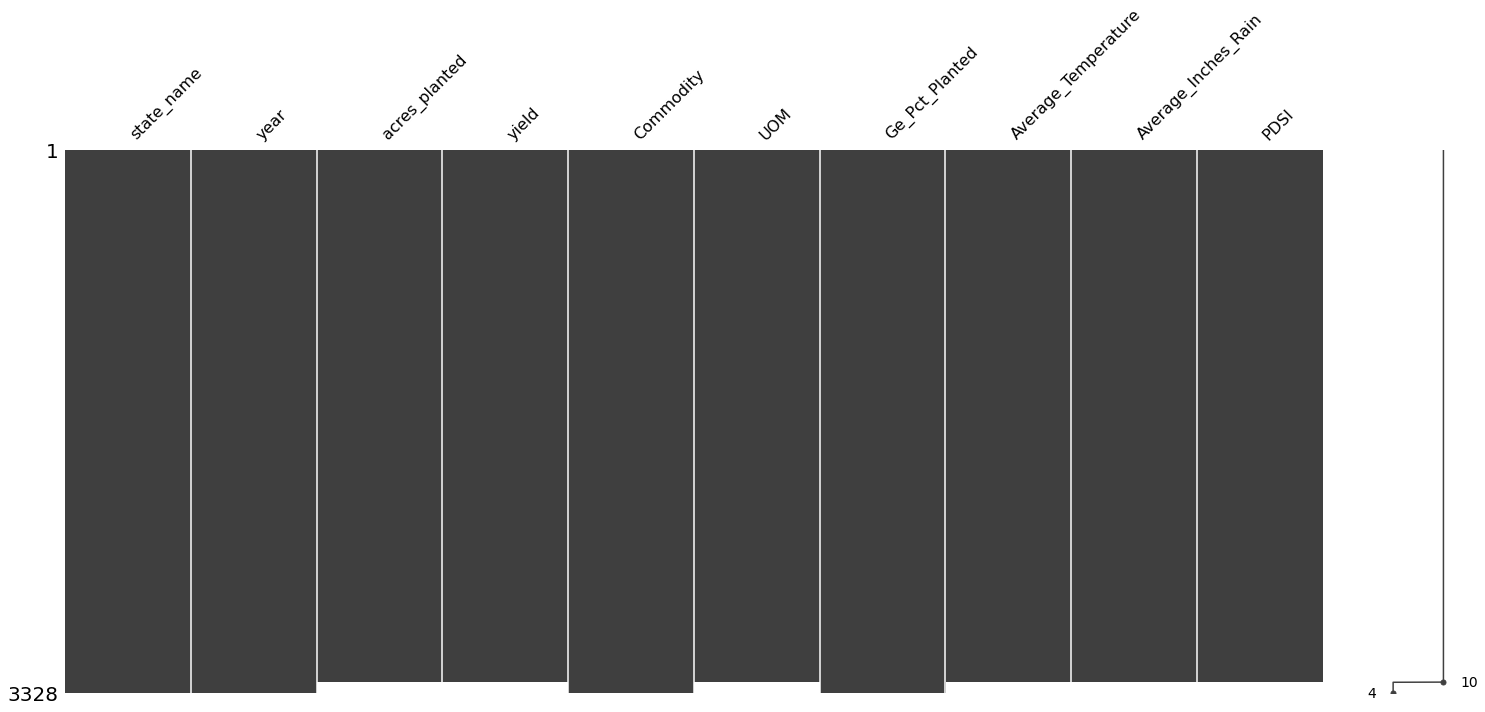

In [131]:
#check for missing data
ms.matrix(climate_data1)

In [132]:
is_nan_climate = climate_data1[climate_data1.isnull().any(axis=1)]
print(is_nan_climate)

        state_name  year acres_planted yield Commodity  UOM  Ge_Pct_Planted  \
3259  OTHER STATES  2000           NaN   NaN      CORN  NaN            17.0   
3260  OTHER STATES  2001           NaN   NaN      CORN  NaN            20.0   
3261  OTHER STATES  2002           NaN   NaN      CORN  NaN            27.0   
3262  OTHER STATES  2003           NaN   NaN      CORN  NaN            36.0   
3263  OTHER STATES  2004           NaN   NaN      CORN  NaN            46.0   
...            ...   ...           ...   ...       ...  ...             ...   
3323  OTHER STATES  2018           NaN   NaN    COTTON  NaN            98.0   
3324  OTHER STATES  2019           NaN   NaN    COTTON  NaN            98.0   
3325  OTHER STATES  2020           NaN   NaN    COTTON  NaN            96.0   
3326  OTHER STATES  2021           NaN   NaN    COTTON  NaN            98.0   
3327  OTHER STATES  2022           NaN   NaN    COTTON  NaN            98.0   

      Average_Temperature  Average_Inches_Rain  PDS

In [133]:
climate_missing = climate_data1[climate_data1.isnull().any(axis=1)]
missing_climate = climate_missing["state_name"].value_counts()
print(missing_climate)

OTHER STATES    69
Name: state_name, dtype: int64


In [134]:
#dropping "other states"
climate_data1 = climate_data1.drop(climate_data1[climate_data1.state_name == "OTHER STATES"].index)

<AxesSubplot:>

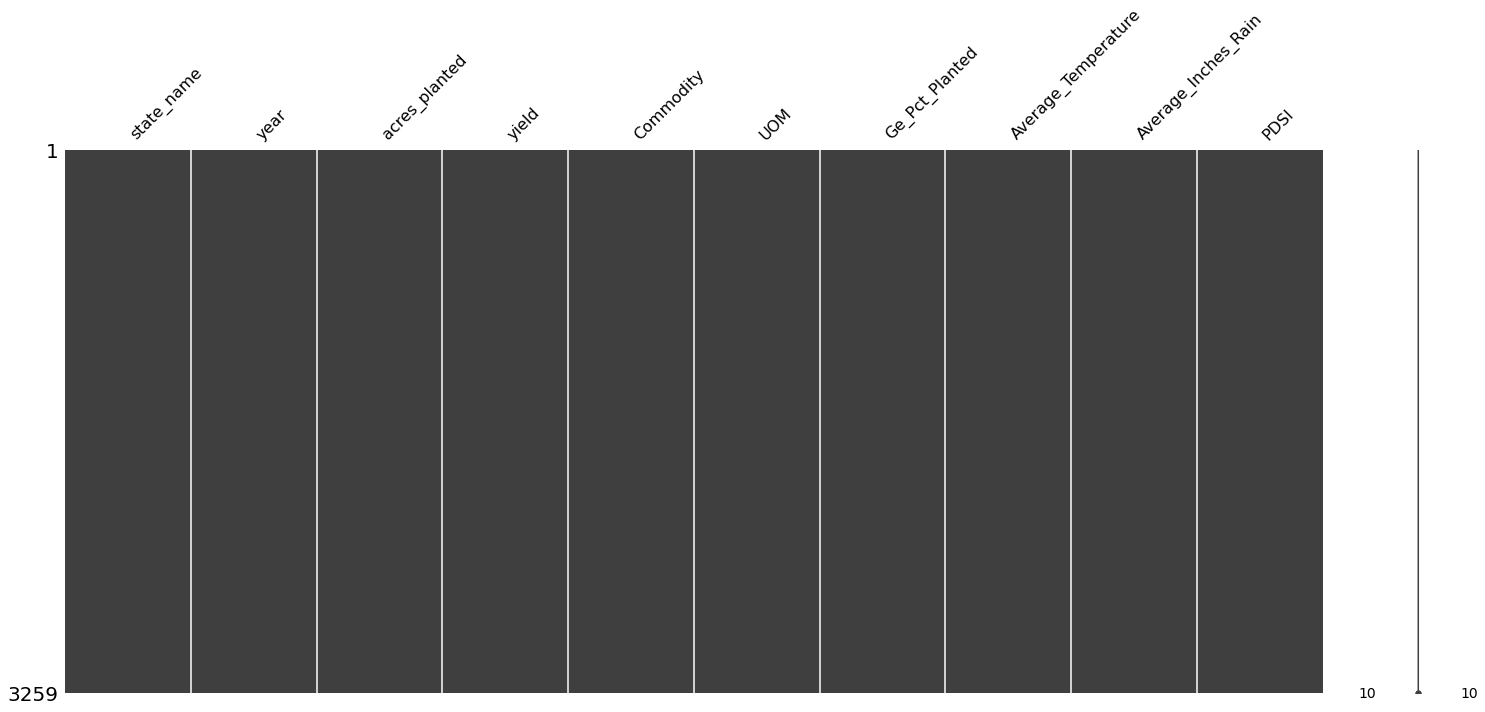

In [135]:
#checking for missing data
ms.matrix(climate_data1)

In [136]:
#renaming for next step
complete_data = climate_data1

## Formatting the data

Now that the data is in one frame, a few transformations on the data types can happen. These transformations are needed for the models later.

In [137]:
complete_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3259 entries, 0 to 3258
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   state_name           3259 non-null   object 
 1   year                 3259 non-null   int64  
 2   acres_planted        3259 non-null   object 
 3   yield                3259 non-null   object 
 4   Commodity            3259 non-null   object 
 5   UOM                  3259 non-null   object 
 6   Ge_Pct_Planted       3259 non-null   float64
 7   Average_Temperature  3259 non-null   float64
 8   Average_Inches_Rain  3259 non-null   float64
 9   PDSI                 3259 non-null   float64
dtypes: float64(4), int64(1), object(5)
memory usage: 280.1+ KB


### Split by Commodity and Filter for States in Scope

Next we will split the dataframes by years, pre-GE (1986-1999) and post-GE (2000-2022). Since the biotech data only includes states that account for the top 90% of all production for that particular crop (provided by USDA), we will only be analyzing the states that have genetically engineered planted percentages and dropping the other states that do not have that information. We will keep all the years in the analysis and end up with three datasets, one for each commodity.

In [138]:
#creating the corn dataframe
corn_data = complete_data[complete_data['Commodity'] == 'CORN']

In [139]:
corn_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1517 entries, 0 to 1516
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   state_name           1517 non-null   object 
 1   year                 1517 non-null   int64  
 2   acres_planted        1517 non-null   object 
 3   yield                1517 non-null   object 
 4   Commodity            1517 non-null   object 
 5   UOM                  1517 non-null   object 
 6   Ge_Pct_Planted       1517 non-null   float64
 7   Average_Temperature  1517 non-null   float64
 8   Average_Inches_Rain  1517 non-null   float64
 9   PDSI                 1517 non-null   float64
dtypes: float64(4), int64(1), object(5)
memory usage: 130.4+ KB


In [140]:
#splitting for post GE
split_1 = corn_data[corn_data['year'] >= 2000]

In [141]:
#checking the data
split_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 943 entries, 14 to 1516
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   state_name           943 non-null    object 
 1   year                 943 non-null    int64  
 2   acres_planted        943 non-null    object 
 3   yield                943 non-null    object 
 4   Commodity            943 non-null    object 
 5   UOM                  943 non-null    object 
 6   Ge_Pct_Planted       943 non-null    float64
 7   Average_Temperature  943 non-null    float64
 8   Average_Inches_Rain  943 non-null    float64
 9   PDSI                 943 non-null    float64
dtypes: float64(4), int64(1), object(5)
memory usage: 81.0+ KB


In [142]:
#filtering for states that have a percentage of genetically engineered seeds planted value
split_1 = split_1[split_1['Ge_Pct_Planted'] > 0.0]

In [143]:
#checking the states
split_1.state_name.unique()

array(['ILLINOIS', 'INDIANA', 'IOWA', 'KANSAS', 'MICHIGAN', 'MINNESOTA',
       'MISSOURI', 'NEBRASKA', 'NORTH DAKOTA', 'OHIO', 'SOUTH DAKOTA',
       'TEXAS', 'WISCONSIN'], dtype=object)

In [144]:
#checking the years
split_1.year.unique()

array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021,
       2022], dtype=int64)

In [145]:
#creating a state name list to filter pre-GE years
state_list = split_1.state_name.unique()

In [146]:
#creating the dataframe for pre-GE years
split_2 = corn_data[corn_data['year'] <= 1999]

In [147]:
split_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 574 entries, 0 to 1493
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   state_name           574 non-null    object 
 1   year                 574 non-null    int64  
 2   acres_planted        574 non-null    object 
 3   yield                574 non-null    object 
 4   Commodity            574 non-null    object 
 5   UOM                  574 non-null    object 
 6   Ge_Pct_Planted       574 non-null    float64
 7   Average_Temperature  574 non-null    float64
 8   Average_Inches_Rain  574 non-null    float64
 9   PDSI                 574 non-null    float64
dtypes: float64(4), int64(1), object(5)
memory usage: 49.3+ KB


In [148]:
#checking the years
split_2.year.unique()

array([1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996,
       1997, 1998, 1999], dtype=int64)

In [149]:
#filtering for the states in scope
split_2 = split_2[split_2['state_name'].isin(state_list)]

In [150]:
#checking the state names
split_2.state_name.unique()

array(['ILLINOIS', 'INDIANA', 'IOWA', 'KANSAS', 'MICHIGAN', 'MINNESOTA',
       'MISSOURI', 'NEBRASKA', 'NORTH DAKOTA', 'OHIO', 'SOUTH DAKOTA',
       'TEXAS', 'WISCONSIN'], dtype=object)

In [151]:
corn_data = pd.concat([split_1, split_2])

In [152]:
corn_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 481 entries, 347 to 1456
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   state_name           481 non-null    object 
 1   year                 481 non-null    int64  
 2   acres_planted        481 non-null    object 
 3   yield                481 non-null    object 
 4   Commodity            481 non-null    object 
 5   UOM                  481 non-null    object 
 6   Ge_Pct_Planted       481 non-null    float64
 7   Average_Temperature  481 non-null    float64
 8   Average_Inches_Rain  481 non-null    float64
 9   PDSI                 481 non-null    float64
dtypes: float64(4), int64(1), object(5)
memory usage: 41.3+ KB


In [153]:
#Removing the commas from the Value column numbers to later cast to INT data type
corn_data['acres_planted']=corn_data['acres_planted'].str.replace(',', '')

In [154]:
#Casting Value column to datatype INT
corn_data['acres_planted']=corn_data['acres_planted'].astype('int')

In [155]:
#Removing the commas from the Value column numbers to later cast to INT data type
corn_data['yield']=corn_data['yield'].str.replace(',', '')

In [156]:
#Casting Value column to datatype INT
corn_data['yield']=corn_data['yield'].astype('float')

In [157]:
corn_data.year.unique()

array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021,
       2022, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995,
       1996, 1997, 1998, 1999], dtype=int64)

In [158]:
corn_data.Commodity.unique()

array(['CORN'], dtype=object)

<AxesSubplot:>

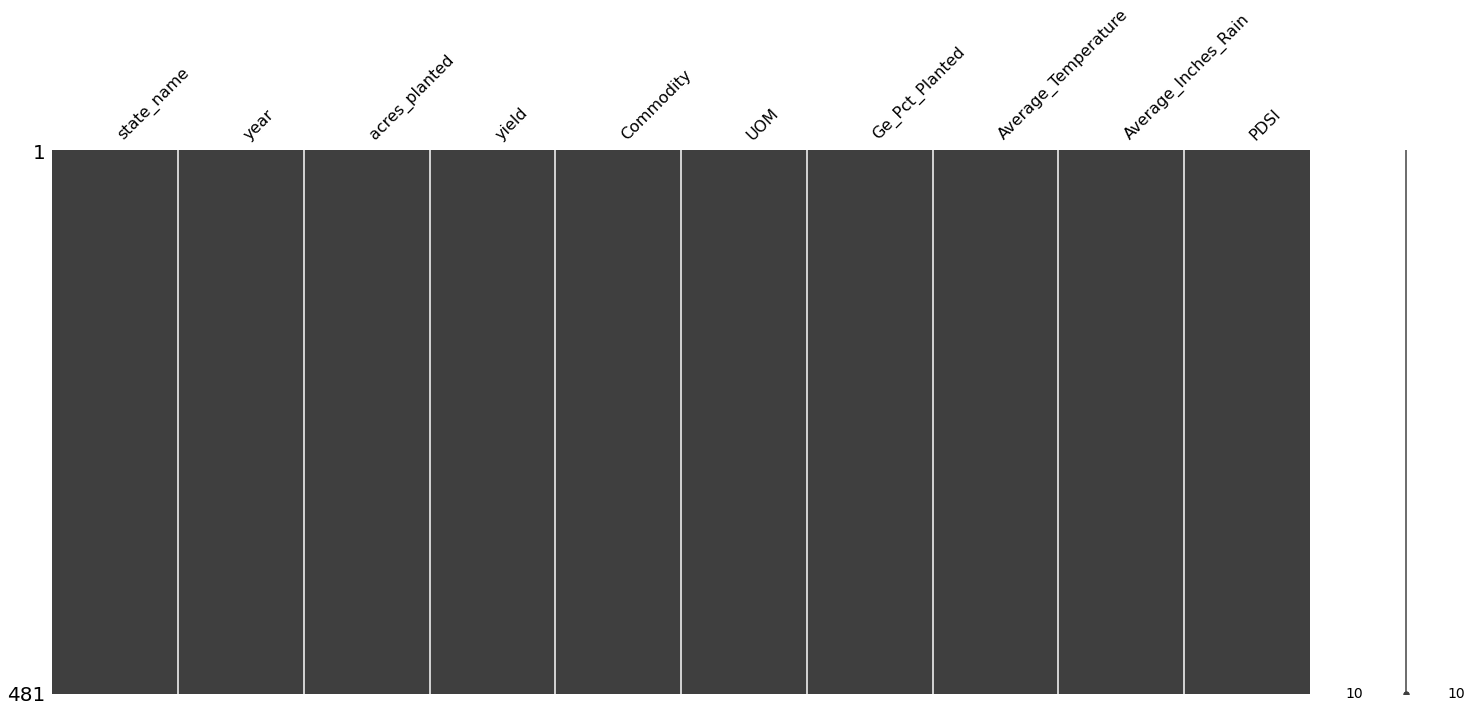

In [159]:
ms.matrix(corn_data)

## Soybean Split and Wrangle

We will perform the same steps on the soybean commodity

In [160]:
#creating the soy dataframe
soy_data = complete_data[complete_data['Commodity'] == 'SOYBEAN']

In [161]:
#split_soyting for post GE
split_soy_1 = soy_data[soy_data['year'] >= 2000]

In [162]:
#checking the data
split_soy_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 705 entries, 1531 to 2629
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   state_name           705 non-null    object 
 1   year                 705 non-null    int64  
 2   acres_planted        705 non-null    object 
 3   yield                705 non-null    object 
 4   Commodity            705 non-null    object 
 5   UOM                  705 non-null    object 
 6   Ge_Pct_Planted       705 non-null    float64
 7   Average_Temperature  705 non-null    float64
 8   Average_Inches_Rain  705 non-null    float64
 9   PDSI                 705 non-null    float64
dtypes: float64(4), int64(1), object(5)
memory usage: 60.6+ KB


In [163]:
#filtering for states that have a percentage of genetically engineered seeds planted value
split_soy_1 = split_soy_1[split_soy_1['Ge_Pct_Planted'] > 0.0]

In [164]:
#checking the states
split_soy_1.state_name.unique()

array(['ARKANSAS', 'ILLINOIS', 'INDIANA', 'IOWA', 'KANSAS', 'MICHIGAN',
       'MINNESOTA', 'MISSISSIPPI', 'MISSOURI', 'NEBRASKA', 'NORTH DAKOTA',
       'OHIO', 'SOUTH DAKOTA', 'WISCONSIN'], dtype=object)

In [165]:
#checking the years
split_soy_1.year.unique()

array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021,
       2022], dtype=int64)

In [166]:
#creating a state name list to filter pre-GE years
state_list = split_soy_1.state_name.unique()

In [167]:
#creating the dataframe for pre-GE years
split_soy_2 = soy_data[soy_data['year'] <= 1999]

In [168]:
#checking the years
split_soy_2.year.unique()

array([1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996,
       1997, 1998, 1999], dtype=int64)

In [169]:
#filtering for the states in scope
split_soy_2 = split_soy_2[split_soy_2['state_name'].isin(state_list)]

In [170]:
#checking the state names
split_soy_2.state_name.unique()

array(['ARKANSAS', 'ILLINOIS', 'INDIANA', 'IOWA', 'KANSAS', 'MICHIGAN',
       'MINNESOTA', 'MISSISSIPPI', 'MISSOURI', 'NEBRASKA', 'NORTH DAKOTA',
       'OHIO', 'SOUTH DAKOTA', 'WISCONSIN'], dtype=object)

In [171]:
soy_data = pd.concat([split_soy_1, split_soy_2], ignore_index=True)

In [172]:
soy_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 518 entries, 0 to 517
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   state_name           518 non-null    object 
 1   year                 518 non-null    int64  
 2   acres_planted        518 non-null    object 
 3   yield                518 non-null    object 
 4   Commodity            518 non-null    object 
 5   UOM                  518 non-null    object 
 6   Ge_Pct_Planted       518 non-null    float64
 7   Average_Temperature  518 non-null    float64
 8   Average_Inches_Rain  518 non-null    float64
 9   PDSI                 518 non-null    float64
dtypes: float64(4), int64(1), object(5)
memory usage: 40.6+ KB


In [173]:
#Removing the commas from the Value column numbers to later cast to INT data type
soy_data['acres_planted']=soy_data['acres_planted'].str.replace(',', '')

In [174]:
#Casting Value column to datatype INT
soy_data['acres_planted']=soy_data['acres_planted'].astype('int')

In [175]:
#Removing the commas from the Value column numbers to later cast to INT data type
soy_data['yield']=soy_data['yield'].str.replace(',', '')

In [176]:
#Casting Value column to datatype INT
soy_data['yield']=soy_data['yield'].astype('float')

In [177]:
soy_data.year.unique()

array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021,
       2022, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995,
       1996, 1997, 1998, 1999], dtype=int64)

In [178]:
soy_data.Commodity.unique()

array(['SOYBEAN'], dtype=object)

<AxesSubplot:>

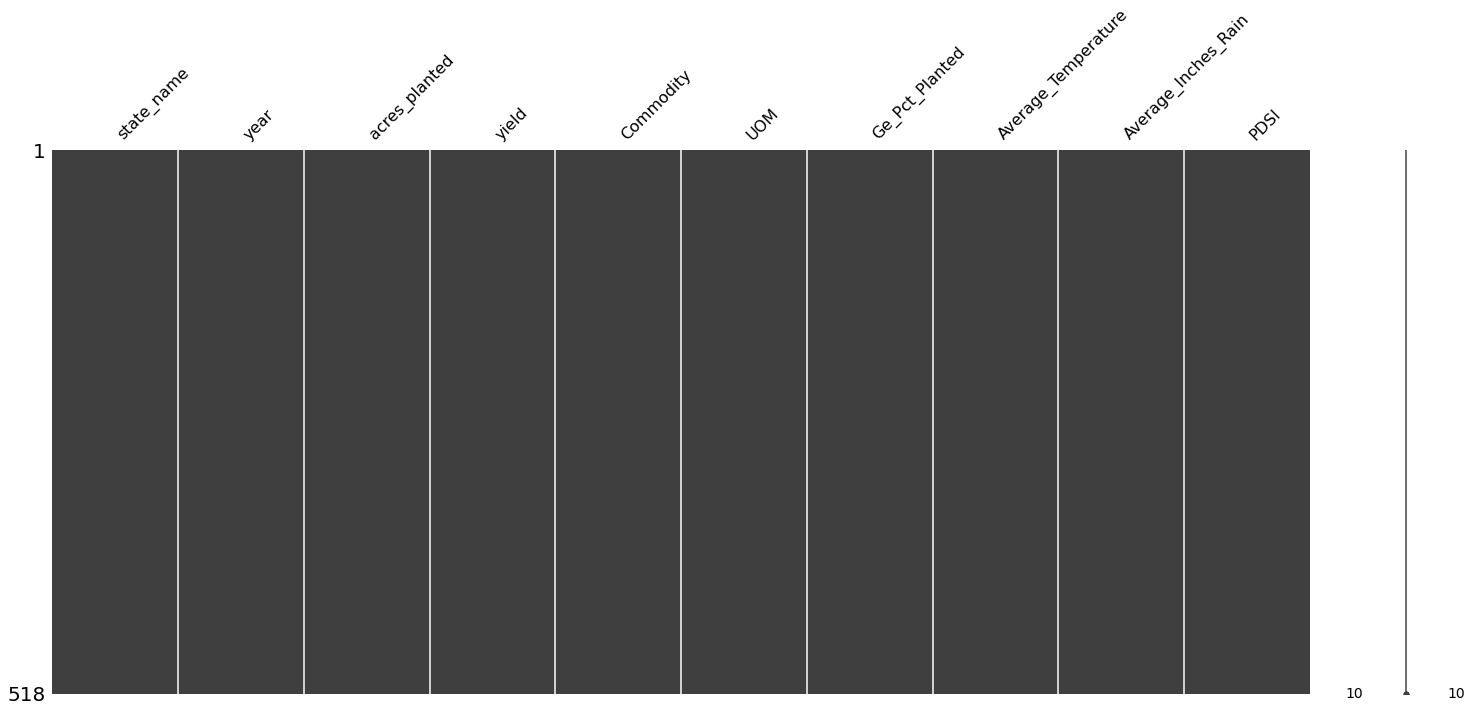

In [179]:
ms.matrix(soy_data)

## Cotton Split and Wrangle

Performing the same steps for the cotton commodity

In [180]:
#creating the cotton dataframe
cotton_data = complete_data[complete_data['Commodity'] == 'COTTON']

In [181]:
#split_cottonting for post GE
split_cotton_1 = cotton_data[cotton_data['year'] >= 2000]

In [182]:
#checking the data
split_cotton_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 391 entries, 2644 to 3258
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   state_name           391 non-null    object 
 1   year                 391 non-null    int64  
 2   acres_planted        391 non-null    object 
 3   yield                391 non-null    object 
 4   Commodity            391 non-null    object 
 5   UOM                  391 non-null    object 
 6   Ge_Pct_Planted       391 non-null    float64
 7   Average_Temperature  391 non-null    float64
 8   Average_Inches_Rain  391 non-null    float64
 9   PDSI                 391 non-null    float64
dtypes: float64(4), int64(1), object(5)
memory usage: 33.6+ KB


In [183]:
#filtering for states that have a percentage of genetically engineered seeds planted value
split_cotton_1 = split_cotton_1[split_cotton_1['Ge_Pct_Planted'] > 0.0]

In [184]:
#checking the states
split_cotton_1.state_name.unique()

array(['ALABAMA', 'ARKANSAS', 'CALIFORNIA', 'GEORGIA', 'LOUISIANA',
       'MISSISSIPPI', 'MISSOURI', 'NORTH CAROLINA', 'TENNESSEE', 'TEXAS'],
      dtype=object)

In [185]:
#checking the years
split_cotton_1.year.unique()

array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021,
       2022], dtype=int64)

In [186]:
#creating a state name list to filter pre-GE years
state_list = split_cotton_1.state_name.unique()

In [187]:
#creating the dataframe for pre-GE years
split_cotton_2 = cotton_data[cotton_data['year'] <= 1999]

In [188]:
#checking the years
split_cotton_2.year.unique()

array([1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996,
       1997, 1998, 1999], dtype=int64)

In [189]:
#filtering for the states in scope
split_cotton_2 = split_cotton_2[split_cotton_2['state_name'].isin(state_list)]

In [190]:
#checking the state names
split_cotton_2.state_name.unique()

array(['ALABAMA', 'ARKANSAS', 'CALIFORNIA', 'GEORGIA', 'LOUISIANA',
       'MISSISSIPPI', 'MISSOURI', 'NORTH CAROLINA', 'TENNESSEE', 'TEXAS'],
      dtype=object)

In [191]:
#checking the years
split_cotton_2.year.unique()

array([1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996,
       1997, 1998, 1999], dtype=int64)

In [192]:
cotton_data = pd.concat([split_cotton_1, split_cotton_2], ignore_index=True)

In [193]:
cotton_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360 entries, 0 to 359
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   state_name           360 non-null    object 
 1   year                 360 non-null    int64  
 2   acres_planted        360 non-null    object 
 3   yield                360 non-null    object 
 4   Commodity            360 non-null    object 
 5   UOM                  360 non-null    object 
 6   Ge_Pct_Planted       360 non-null    float64
 7   Average_Temperature  360 non-null    float64
 8   Average_Inches_Rain  360 non-null    float64
 9   PDSI                 360 non-null    float64
dtypes: float64(4), int64(1), object(5)
memory usage: 28.2+ KB


In [194]:
#Removing the commas from the Value column numbers to later cast to INT data type
cotton_data['acres_planted']=cotton_data['acres_planted'].str.replace(',', '')

In [195]:
#Casting Value column to datatype INT
cotton_data['acres_planted']=cotton_data['acres_planted'].astype('int')

In [196]:
#Removing the commas from the Value column numbers to later cast to INT data type
cotton_data['yield']=cotton_data['yield'].str.replace(',', '')

In [197]:
#Casting Value column to datatype INT
cotton_data['yield']=cotton_data['yield'].astype('float')

In [198]:
cotton_data.year.unique()

array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021,
       2022, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995,
       1996, 1997, 1998, 1999], dtype=int64)

In [199]:
cotton_data.Commodity.unique()

array(['COTTON'], dtype=object)

<AxesSubplot:>

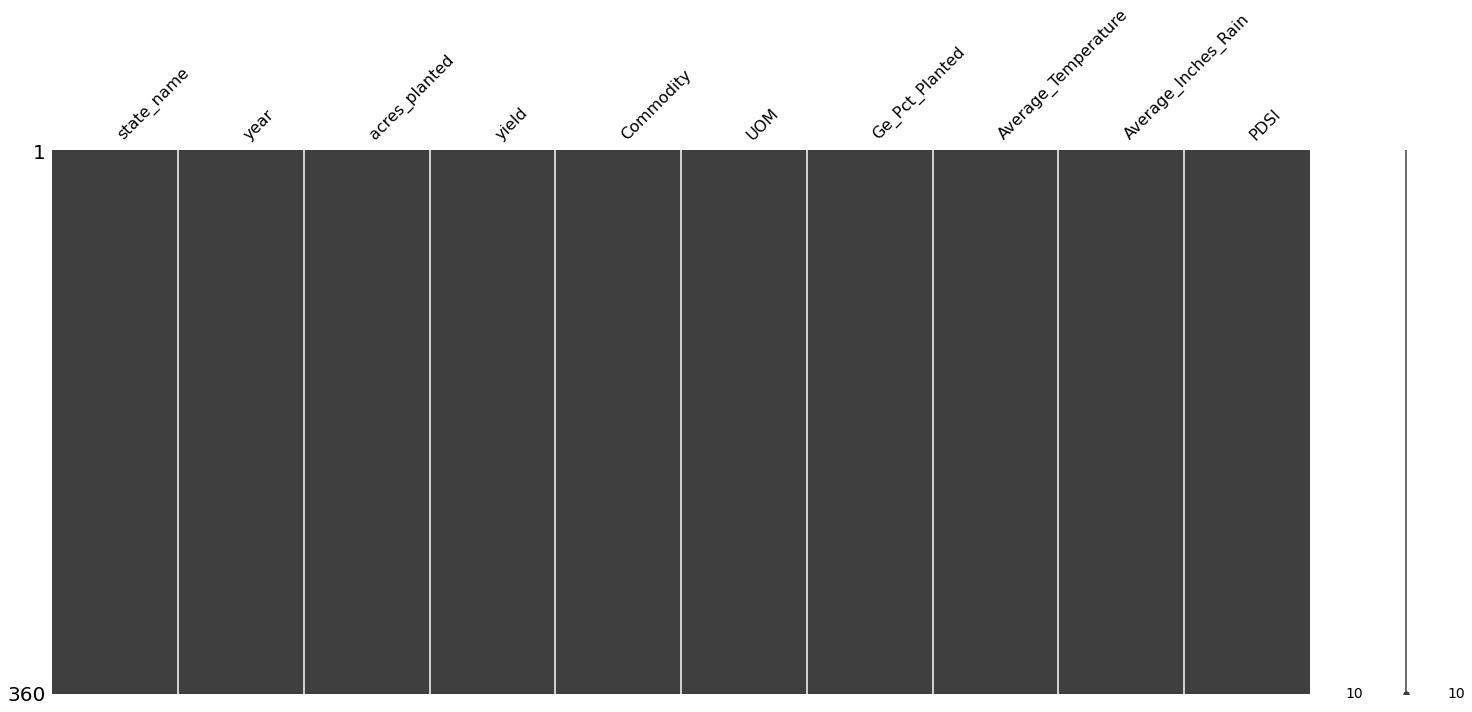

In [200]:
ms.matrix(cotton_data)

## Initial Investigation Dataset

The combined dataset is complete and now can be used for a first look in Tableau. Using this data in Tableau will assist with building and adjusting the models. The data will be combined and exported to a csv format.

In [201]:
#combine the dataframes
combined_data = pd.concat([corn_data, soy_data, cotton_data], ignore_index=True)

In [202]:
#creating new dataframes for modeling
corn_model_data = corn_data
soy_model_data = soy_data
cotton_model_data = cotton_data

In [203]:
#exporting to csv for initial view
combined_data.to_csv('combined_data.csv')

## Model Preparation: CORN

#### Interpolating the GE % planted for years 1996-1999

It is know that for years 1996-1999 we do not have data for the percentage of genetically engineered seeds planted. While implementation began in 1996, and overall charts exist that give indication of the adoption rate for those years, we do not have any exact data until year 2000. To account for this in the model, we will interpolate the values based on the value that is in 2000, and deincrement the values evenly all the way down to zero for 1995.

Then, we will include data with zero genetically engineered seeds planted for 5 years to give an even representation of before genetically engineered seeds were introducted without heavy inflation of zeros in the model. 

In [204]:
# Getting the list of unique states
states = corn_model_data['state_name'].unique()

# Looping through each state and manually calculating and assign the GE percentage for each year
for state in states:
    # Getting the GE percentage for the year 2000 for the current state
    ge_pct_2000 = corn_model_data.loc[(corn_model_data['state_name'] == state) & (corn_model_data['year'] == 2000), 'Ge_Pct_Planted'].values[0]

    # Calculating the yearly increment for the GE percentage
    yearly_increment = ge_pct_2000 / 5  # We divide by 5 because we're distributing the value over 5 years (1996 to 2000) and need 1995 to equal 0

    # Assigning the calculated GE percentages for each year from 1996 to 1999
    for year in range(1996, 2000):
        corn_model_data.loc[(corn_model_data['state_name'] == state) & (corn_model_data['year'] == year), 'Ge_Pct_Planted'] = yearly_increment * (year - 1995)


In [205]:
#checking the values
corn_model_data[(corn_model_data['year'] >= 1996) & (corn_model_data['year'] <= 2000)][['state_name', 'year', 'Ge_Pct_Planted']]

,state_name,year,Ge_Pct_Planted
347,ILLINOIS,2000,17.0
384,INDIANA,2000,11.0
421,IOWA,2000,30.0
458,KANSAS,2000,33.0
606,MICHIGAN,2000,12.0
...,...,...,...
1271,TEXAS,1999,33.6
1453,WISCONSIN,1996,3.6
1454,WISCONSIN,1997,7.2
1455,WISCONSIN,1998,10.8


### Checking the Distributions of the features

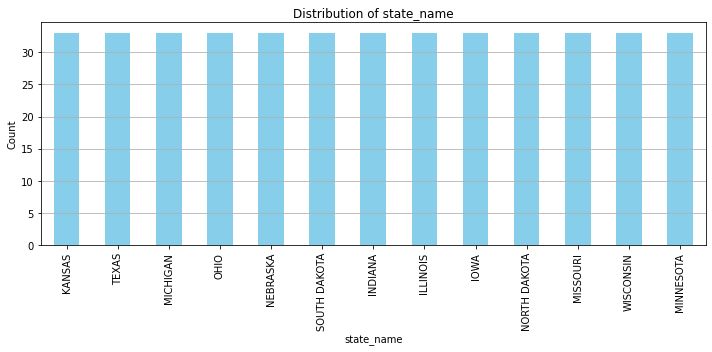

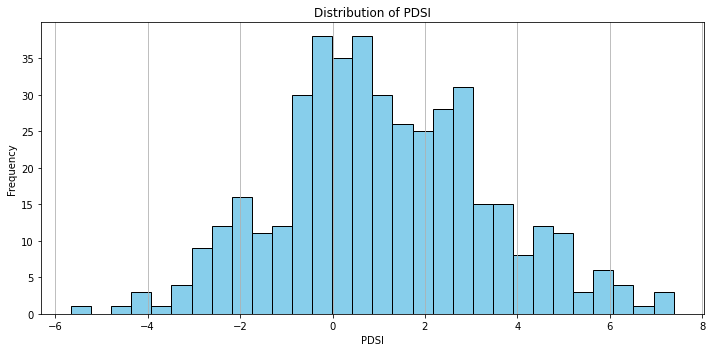

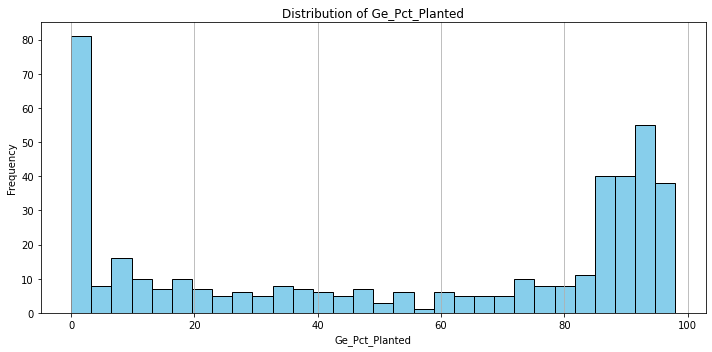

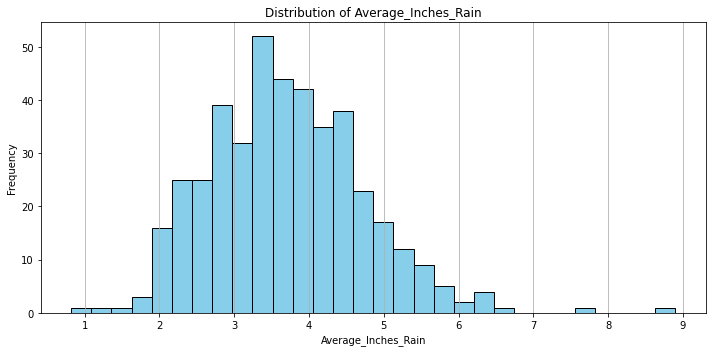

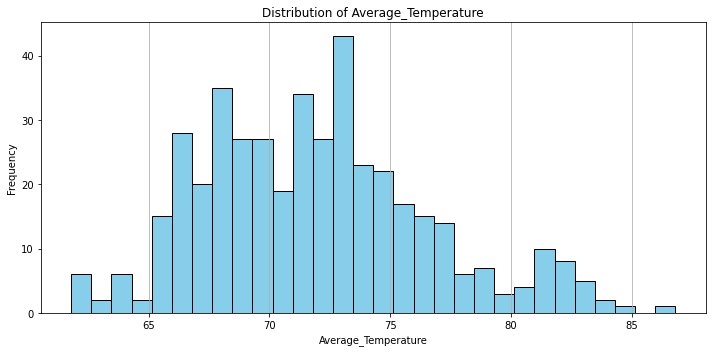

In [206]:
# List of variables
variables = ['state_name', 'PDSI', 'Ge_Pct_Planted', 'Average_Inches_Rain', 'Average_Temperature']
corn_model_data = corn_model_data[corn_model_data['year'] >= 1990]

# Plotting histograms for each variable
for var in variables:
    plt.figure(figsize=(10, 5))
    
    # For categorical variable 'state_name', we'll use a bar plot to show the counts
    if var == 'state_name':
        corn_model_data[var].value_counts().plot(kind='bar', color='skyblue')
        plt.title(f'Distribution of {var}')
        plt.ylabel('Count')
    else:
        corn_model_data[var].hist(bins=30, color='skyblue', edgecolor='black')
        plt.title(f'Distribution of {var}')
        plt.ylabel('Frequency')
    
    plt.xlabel(var)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

### Checking correlation of the features

In [207]:
#selecting columns for correlation matrix
selected_columns = ['yield', 'Ge_Pct_Planted', 'PDSI', 'Average_Temperature', 'Average_Inches_Rain', 'year', 'acres_planted']

# Create a subset DataFrame with the selected columns
subset_data = corn_model_data[selected_columns]

# Compute the correlation matrix
correlation_matrix = subset_data.corr()

# Display the correlation matrix
print(correlation_matrix)

                        yield  Ge_Pct_Planted      PDSI  Average_Temperature  \
yield                1.000000        0.536984  0.146441            -0.047678   
Ge_Pct_Planted       0.536984        1.000000  0.010615             0.115344   
PDSI                 0.146441        0.010615  1.000000            -0.255817   
Average_Temperature -0.047678        0.115344 -0.255817             1.000000   
Average_Inches_Rain  0.353855       -0.069467  0.439735            -0.164244   
year                 0.611529        0.930606  0.015255             0.120776   
acres_planted        0.491616        0.119599  0.052543            -0.033123   

                     Average_Inches_Rain      year  acres_planted  
yield                           0.353855  0.611529       0.491616  
Ge_Pct_Planted                 -0.069467  0.930606       0.119599  
PDSI                            0.439735  0.015255       0.052543  
Average_Temperature            -0.164244  0.120776      -0.033123  
Average_Inches_Rain

### Avoiding Multi-colliniearity

From the correlation matrix above we can see that a few of the independent variables are highly correlated (Ge_Pct_Planted and year). We will not be using the year variable in the model due to this factor. There are other features that have moderate correlation, including PDSI and average_inches_rain, we will likely need to exclude this feature and only include the average temperature. 

Even though random forest can work with multicolliniearity, this can present an issue with the model attempting to find the strongest predictor. We will test the model and see which features contribute to the strength of the model and which ones do not.

### Linear Relationships

Next we will look at the linear relationships between our dependent variable crop_yield and our main feature % of genetically engineered seeds planted. While random forest also can deal with non-linearity, I want to check and see which states might identify as an outlier within these features.

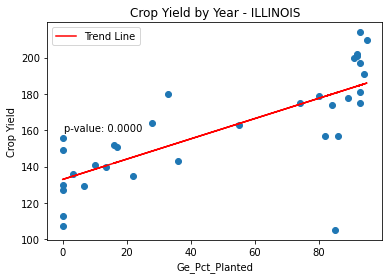

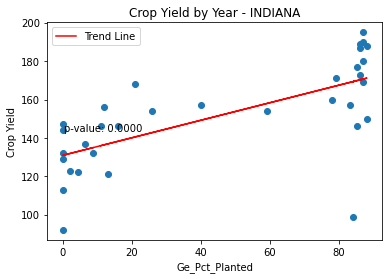

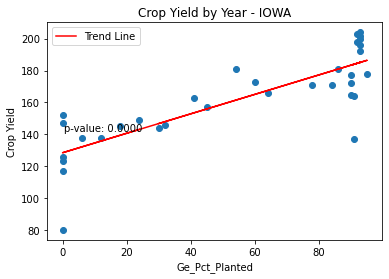

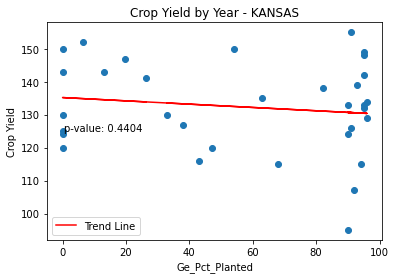

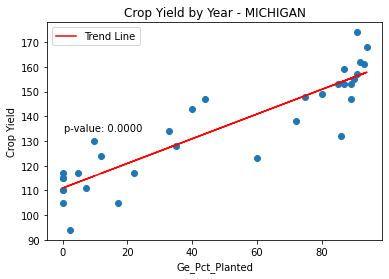

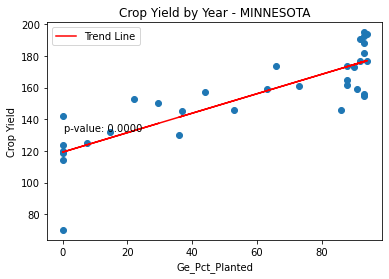

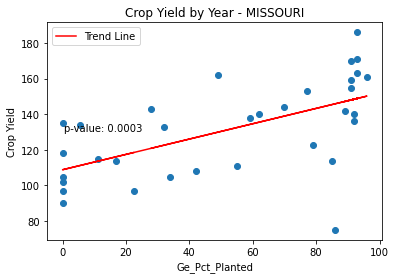

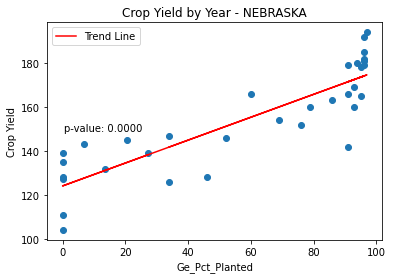

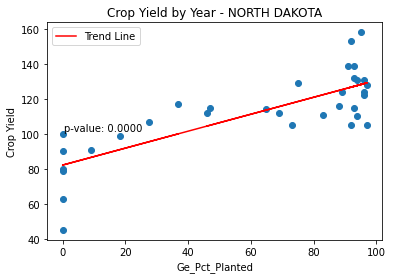

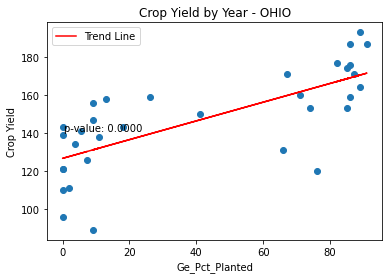

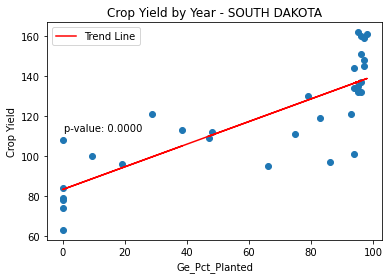

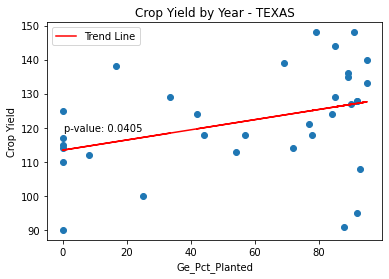

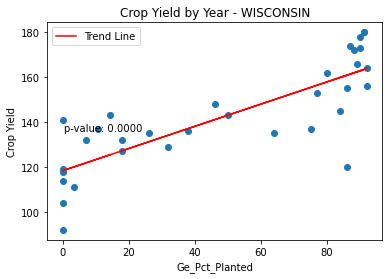

In [208]:
from scipy.stats import linregress

#filtering for current years with genetically engineered seeds planted
corn_model_data = corn_model_data[corn_model_data['year'] >= 1990]

# Getting the list of unique states
states = corn_model_data['state_name'].unique()

# Plotting for each state
for state in states:
    # Filtering the data for the current state
    state_data = corn_model_data[corn_model_data['state_name'] == state]
    
    # Creating a new plot for each state
    plt.figure()
    
    # Creating the scatter plot for the current state
    plt.scatter(state_data['Ge_Pct_Planted'], state_data['yield'])
    
    # Fitting a linear regression line to the data points
    slope, intercept, r_value, p_value, _ = linregress(state_data['Ge_Pct_Planted'], state_data['yield'])
    trendline = intercept + slope * state_data['Ge_Pct_Planted']
    
    # Plotting the trend line
    plt.plot(state_data['Ge_Pct_Planted'], trendline, color='red', label='Trend Line')
    
    # Setting the title and labels for the current state
    plt.title(f'Crop Yield by Year - {state}')
    plt.xlabel('Ge_Pct_Planted')
    plt.ylabel('Crop Yield')
    
    # Notating the p-value on the plot
    plt.text(0.05, 0.5, f'p-value: {p_value:.4f}', transform=plt.gca().transAxes)
    
    # Showing the legend
    plt.legend()
    
    # Showing the plot for each state
    plt.show()

In [209]:
corn_model_data.year.unique()

array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021,
       2022, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999],
      dtype=int64)

## Outlier 

From the above plots we can observe that Kansas does not follow a linear pattern when comparing the year and crop yield variables. We will remove Kansas from the analysis as an outlier.

In [210]:
#dropping Kansas as it does not have a linear pattern
corn_model_data = corn_model_data[corn_model_data['state_name'] != 'KANSAS']

# Random Forest Models

Next, I will create the models to observe the variables that are going to be visualized in Tableau. Due to the limited text display functions within Tableau, and since Tableau does not have function to create multi-linear regression models, I will test in python and based on the results create the corresponding plots in Tableau. The project's intention is to create an easy to interpret dashboard that anyone, regardless of technical level, can understand and explore. Creating the models to check the statistical relevance will be key evidence for the stakeholders to make decisions with invested further into this topic.

After performing the analysis on Tableau to observe the linear relationships between the variables, it was observed that the PDSI(Palmer Drought Severity Index) when plotted against the yield per acre showed a polynomial pattern, a curved pattern in the shape of an upside down U. It appeared that this is a polynomial with 2 degrees. Because of that, I will be adding a squared term to the PDSI to account for this. Because I am including a squared term in the model, I will create a centered variable to help mitigate multicollinearity. 

Also, it is noted that the distribution within the Ge_Pct_Planted is not evenly distributed. A large amount of zero's exist for the time periods between 1986-1999 before genetically engineered seeds were being planted commercially, and years where data is not available (1996-1999). Because we know that the zero's do not come from multiple sources and are not missing data or unexplained, but to avoid zero inflation I am going to create groups that create categories for the increasing range of values. The values for years 1996-2000 will be interpolated by simply taking the first year value (year 2000) and incrementing equally down to zero in year 1995. This will give a better indicator for those years, rather than keeping them at 0.

## Creating additional variables

The next two modules create the neccessary variables for the model. The PDSI will be squared to account for the polynomial relationship. Then, the bins for the percentage of genetically engineered seeds to be used as a category in the model. After that, the state_name category is created by identifying the baseline state. The baseline state will be the state that performs closest to the median yield for all states. This will give us an indicator of each states performance when compared to the mean.

In [211]:
# Center PDSI by subtracting its mean from each of its values
corn_model_data['PDSI_centered'] = corn_model_data['PDSI'] - corn_model_data['PDSI'].mean()
corn_model_data['TEMP_centered'] = corn_model_data['Average_Temperature'] - corn_model_data['Average_Temperature'].mean()
corn_model_data['PRECIP_centered'] = corn_model_data['Average_Inches_Rain'] - corn_model_data['Average_Inches_Rain'].mean()

# Add a squared term for the centered PDSI and Average Rainfall
corn_model_data['PDSI_centered_squared'] = corn_model_data['PDSI_centered'] ** 2
corn_model_data['TEMP_centered_squared'] = corn_model_data['TEMP_centered'] ** 2
corn_model_data['PRECIP_centered_squared'] = corn_model_data['PRECIP_centered'] ** 2

#creating the bins for GE % rating
bins = [-1, 0, 25, 50, 75, 100]

# Define the labels for each category
labels = ["ZERO","<25%", "<50%", "<75%", "<100%"]

# Use pd.cut to create the new variable
corn_model_data['GE_Seeds_Category'] = pd.cut(corn_model_data['Ge_Pct_Planted'], bins=bins, labels=labels)


In [212]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


relevant_features = ['state_name','Ge_Pct_Planted', 'PDSI', 'Average_Temperature', 'yield']
data = corn_model_data[relevant_features]
data = pd.get_dummies(data, columns=['state_name'])

# Split dataset into features and target variable
X = data.drop('yield', axis=1)
y = data['yield']

# Split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict crop yields
y_pred = model.predict(X_test)

MSE:  180.58852750000005
R-Squared:  0.7997604304564911


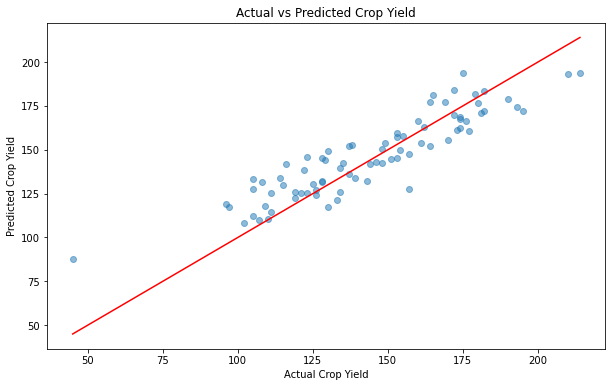

In [213]:
# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('MSE: ', mse)
print('R-Squared: ', r2)

# Plotting actuals vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Crop Yield')
plt.ylabel('Predicted Crop Yield')
plt.title('Actual vs Predicted Crop Yield')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Diagonal line
plt.show()

## Testing Feature Importance:
Understanding which variables most influence crop yield is likely just as important as the predictive capability of the model.

Relevance: Offers insight into the data and the model's decision-making process. In a domain like agriculture, this could lead to actionable insights.

In [214]:
importances = model.feature_importances_
features = X_train.columns

for feature, importance in zip(features, importances):
    print(f"Feature: {feature}, Importance: {importance}")

Feature: Ge_Pct_Planted, Importance: 0.39974737522499076
Feature: PDSI, Importance: 0.1613940270054687
Feature: Average_Temperature, Importance: 0.18706558572554915
Feature: state_name_ILLINOIS, Importance: 0.01285590373479315
Feature: state_name_INDIANA, Importance: 0.004773523495417663
Feature: state_name_IOWA, Importance: 0.01450798451936228
Feature: state_name_MICHIGAN, Importance: 0.0095819360714204
Feature: state_name_MINNESOTA, Importance: 0.0034593066971726548
Feature: state_name_MISSOURI, Importance: 0.009528317462351155
Feature: state_name_NEBRASKA, Importance: 0.00897179734515709
Feature: state_name_NORTH DAKOTA, Importance: 0.09328171529947404
Feature: state_name_OHIO, Importance: 0.005019249621446916
Feature: state_name_SOUTH DAKOTA, Importance: 0.08103473412033452
Feature: state_name_TEXAS, Importance: 0.003559787984973342
Feature: state_name_WISCONSIN, Importance: 0.005218755692088177


### The results from the feature importance analysis give us some interesting points to investigate further. The observations concluded are:

#### 1. Top Features by Importance:
Ge_Pct_Planted (37.9%): This is by far the most significant feature. It suggests that the proportion of genetically engineered seeds planted has the most considerable influence on crop yields. This could imply that genetically engineered seeds have a distinct performance profile when it comes to yield outcomes, maybe due to resistance to certain pests, diseases, or better adaptability to various soil types and weather conditions.

Average_Temperature (23.71%): Temperature plays a pivotal role in crop yield, impacting growth phases, moisture availability, pest activity, etc. Its high importance emphasizes the role of temperature in determining yields.

PDSI (14.01%): The Palmer Drought Severity Index measures prolonged and abnormally dry or wet periods. It's essential because drought or overly wet conditions can severely impact crop growth and development.

#### 2. State Specific Importances:
NORTH DAKOTA (10.40%) and SOUTH DAKOTA (5.58%): These states have considerably higher importance than other states, suggesting they may have distinct patterns or conditions that are especially relevant in determining crop yields. Perhaps there are unique weather conditions, soil types, or farming practices in these states that set them apart from others.

Most other states have feature importance values less than 1%, with a few exceptions like ILLINOIS (1.61%) and IOWA (1.71%). This indicates that, after accounting for other factors like temperature, PDSI, and genetically engineered seed usage, the specific state becomes less crucial for the overall model. However, it doesn't mean the state isn't important; instead, it means the unique variance attributed solely to the state, after considering other features, is relatively low.

## Testing Residuals

Next we will look at the residuals against the predictions to access for heteroscedasticity. We will first visual the results in a plot, then run a Breusch Pagan analysis to statistically access the variables. 

We are running the Breusch Pagan with the assumptions:

Null Hypothesis (H0): Homoskedasticity is present (variance of the errors is constant).
Alternative Hypothesis (H1): Heteroskedasticity is present.

If the 'LM-Test p-value' or the 'F-Test p-value' is less than the significance level (0.05), then the null hypothesis of homoskedasticity is rejected, indicating the presence of heteroskedasticity in the data.

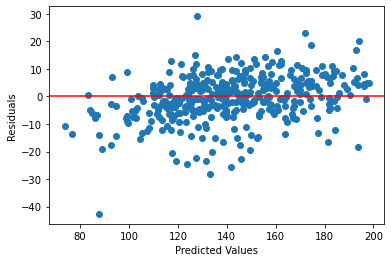

In [215]:
#plotting residuals against predicted values
predictions = model.predict(X)
residuals = y - predictions

plt.scatter(predictions, residuals)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

In [216]:
import statsmodels.api as sm
from statsmodels.compat import lzip
from statsmodels.stats.diagnostic import het_breuschpagan

predictions = model.predict(X)
residuals = y - predictions

bp_test = het_breuschpagan(residuals, X)

labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
result = dict(zip(labels, bp_test))

print(result)

{'LM Statistic': 19.48567629880924, 'LM-Test p-value': 0.14720849483770648, 'F-Statistic': 1.4084159054536463, 'F-Test p-value': 0.14584314411989935}


The results show that we cannot reject the null hypothesis (H0) in favor of the alternative. The LM-Test p-value and F-Test p-value both exceed the significance level of (0.05). This give us a good indication that the model does not have a strong presense of heteroscadasticity.

### OOB

Lastly we will calculate the OOB(Out-Of-Bag) score to see how well the model performs against the untrained samples. This can give us another validation metric for the model.

In [217]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, oob_score=True, random_state=42)
model.fit(X_train, y_train)

print("OOB Score:", model.oob_score_)

OOB Score: 0.6483027551904614


In [218]:
#adding the fitted values to the dataset for export
corn_model_data['Fitted Values'] = model.predict(X)

In [219]:
corn_model_data.to_csv('corn_model_results.csv')

## Overall Predictions vs Actuals

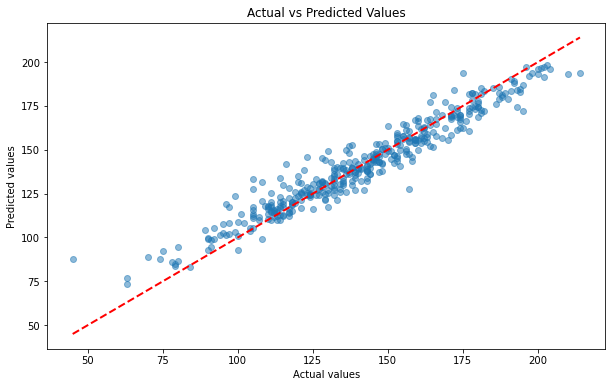

In [220]:
#creating the variables from the model
predicted_values = predictions
actual_values = corn_model_data['yield']

# Creating a scatter plot of actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(actual_values, predictions, alpha=0.5)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title(f'Actual vs Predicted Values')

# Plotting a line representing a perfect prediction
plt.plot([actual_values.min(), actual_values.max()],[actual_values.min(), actual_values.max()], color='red', linestyle='--', lw=2)

plt.show()

## Model Preparation: SOYBEAN

#### Interpolating the GE % planted for years 1996-1999

It is know that for years 1996-1999 we do not have data for the percentage of genetically engineered seeds planted. While implementation began in 1996, and overall charts exist that give indication of the adoption rate for those years, we do not have any exact data until year 2000. To account for this in the model, we will interpolate the values based on the value that is in 2000, and deincrement the values evenly all the way down to zero for 1995.

Then, we will include data with zero genetically engineered seeds planted for 5 years to give an even representation of before genetically engineered seeds were introducted without heavy inflation of zeros in the model. 

In [221]:
# Getting the list of unique states
states = soy_model_data['state_name'].unique()

# Looping through each state and manually calculating and assign the GE percentage for each year
for state in states:
    # Getting the GE percentage for the year 2000 for the current state
    ge_pct_2000 = soy_model_data.loc[(soy_model_data['state_name'] == state) & (soy_model_data['year'] == 2000), 'Ge_Pct_Planted'].values[0]

    # Calculating the yearly increment for the GE percentage
    yearly_increment = ge_pct_2000 / 5  # We divide by 5 because we're distributing the value over 5 years (1996 to 2000) and need 1995 to equal 0

    # Assigning the calculated GE percentages for each year from 1996 to 1999
    for year in range(1996, 2000):
        soy_model_data.loc[(soy_model_data['state_name'] == state) & (soy_model_data['year'] == year), 'Ge_Pct_Planted'] = yearly_increment * (year - 1995)


In [222]:
#checking the values
soy_model_data[(soy_model_data['year'] >= 1996) & (soy_model_data['year'] <= 2000)][['state_name', 'year', 'Ge_Pct_Planted']]

,state_name,year,Ge_Pct_Planted
0,ARKANSAS,2000,43.0
23,ILLINOIS,2000,44.0
46,INDIANA,2000,63.0
69,IOWA,2000,59.0
92,KANSAS,2000,66.0
...,...,...,...
503,SOUTH DAKOTA,1999,54.4
514,WISCONSIN,1996,10.2
515,WISCONSIN,1997,20.4
516,WISCONSIN,1998,30.6


### Checking the Distributions of the features

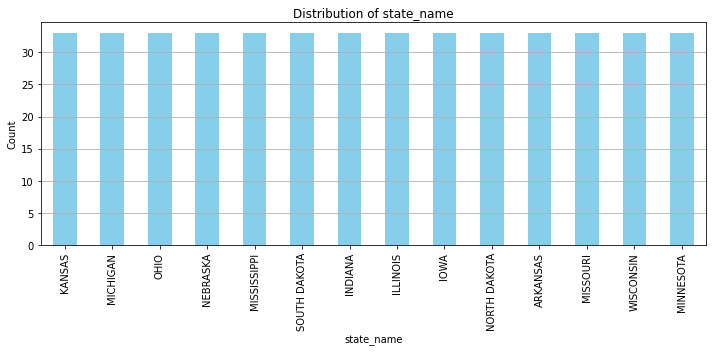

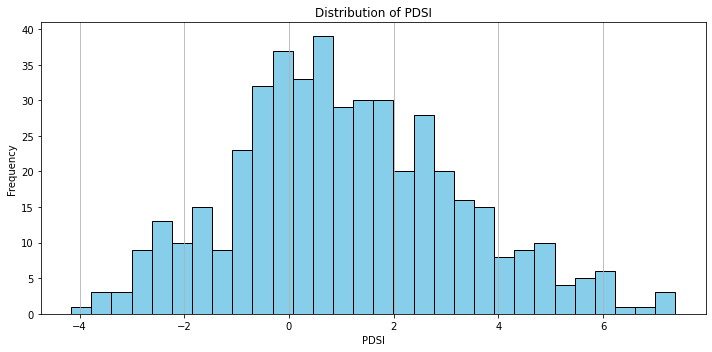

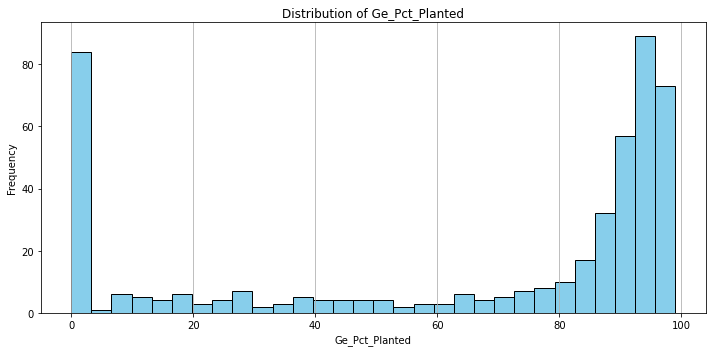

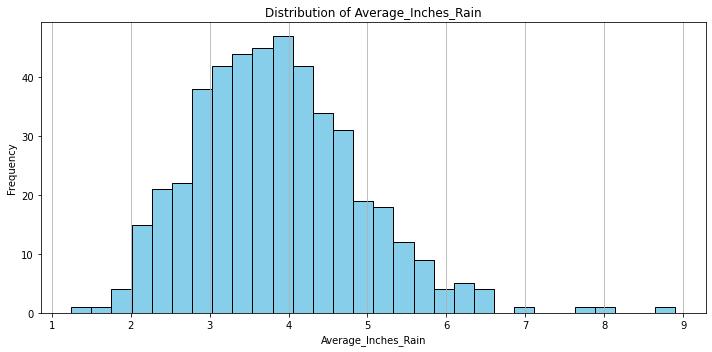

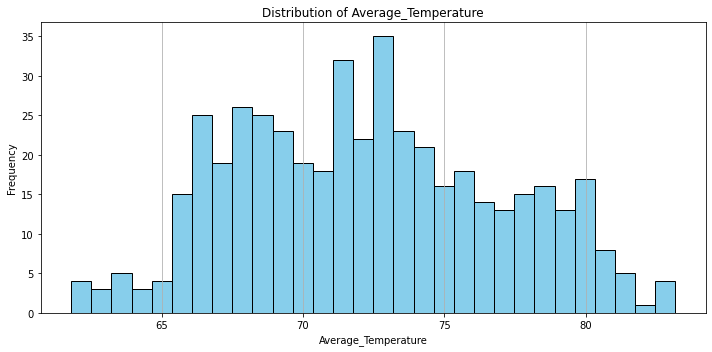

In [223]:
# List of variables
variables = ['state_name', 'PDSI', 'Ge_Pct_Planted', 'Average_Inches_Rain', 'Average_Temperature']
soy_model_data = soy_model_data[soy_model_data['year'] >= 1990]

# Plotting histograms for each variable
for var in variables:
    plt.figure(figsize=(10, 5))
    
    # For categorical variable 'state_name', we'll use a bar plot to show the counts
    if var == 'state_name':
        soy_model_data[var].value_counts().plot(kind='bar', color='skyblue')
        plt.title(f'Distribution of {var}')
        plt.ylabel('Count')
    else:
        soy_model_data[var].hist(bins=30, color='skyblue', edgecolor='black')
        plt.title(f'Distribution of {var}')
        plt.ylabel('Frequency')
    
    plt.xlabel(var)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

### Checking correlation of the features

In [224]:
#selecting columns for correlation matrix
selected_columns = ['yield', 'Ge_Pct_Planted', 'PDSI', 'Average_Temperature', 'Average_Inches_Rain', 'year', 'acres_planted']

# Create a subset DataFrame with the selected columns
subset_data = soy_model_data[selected_columns]

# Compute the correlation matrix
correlation_matrix = subset_data.corr()

# Display the correlation matrix
print(correlation_matrix)

                        yield  Ge_Pct_Planted      PDSI  Average_Temperature  \
yield                1.000000        0.467265  0.187223            -0.020902   
Ge_Pct_Planted       0.467265        1.000000 -0.048893             0.138299   
PDSI                 0.187223       -0.048893  1.000000            -0.224838   
Average_Temperature -0.020902        0.138299 -0.224838             1.000000   
Average_Inches_Rain  0.345394       -0.009185  0.393614             0.120053   
year                 0.592731        0.876924  0.062224             0.112773   
acres_planted        0.422665        0.193468  0.018760             0.006227   

                     Average_Inches_Rain      year  acres_planted  
yield                           0.345394  0.592731       0.422665  
Ge_Pct_Planted                 -0.009185  0.876924       0.193468  
PDSI                            0.393614  0.062224       0.018760  
Average_Temperature             0.120053  0.112773       0.006227  
Average_Inches_Rain

### Avoiding Multi-colliniearity

From the correlation matrix above we can see that a few of the independent variables are highly correlated (Ge_Pct_Planted and year). We will not be using the year variable in the model due to this factor. There are other features that have moderate correlation, including PDSI and average_inches_rain, we will likely need to exclude this feature and only include the average temperature. 

Even though random forest can work with multicolliniearity, this can present an issue with the model attempting to find the strongest predictor. We will test the model and see which features contribute to the strength of the model and which ones do not.

### Linear Relationships

Next we will look at the linear relationships between our dependent variable crop_yield and our main feature % of genetically engineered seeds planted. While random forest also can deal with non-linearity, I want to check and see which states might identify as an outlier within these features.

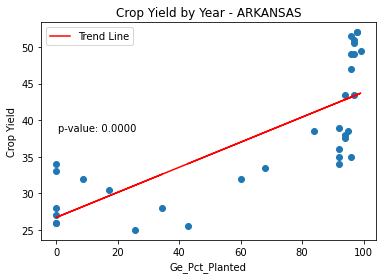

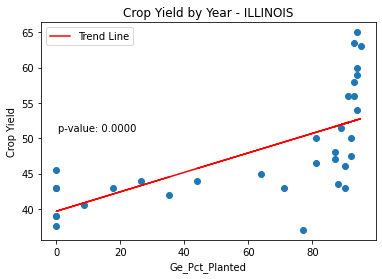

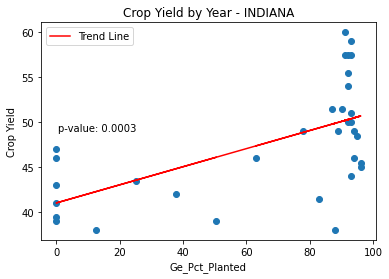

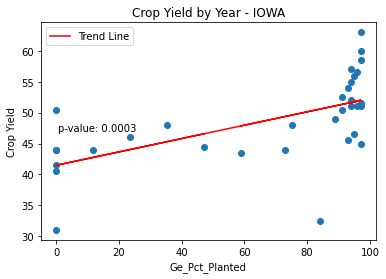

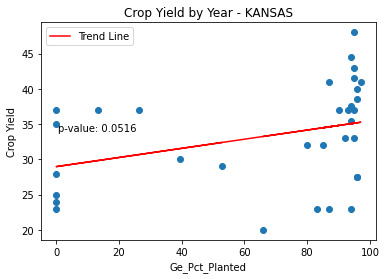

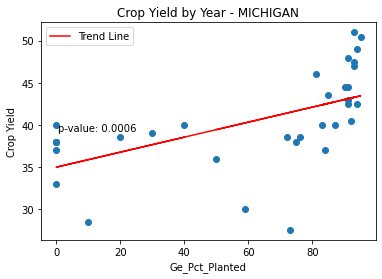

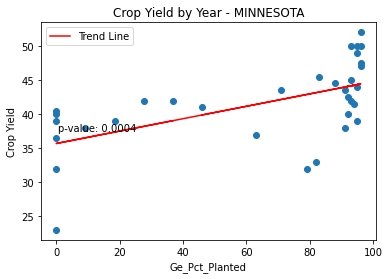

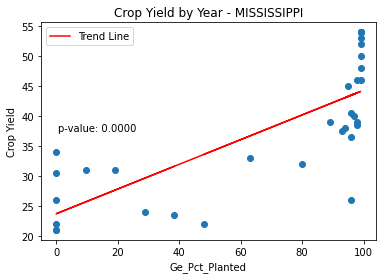

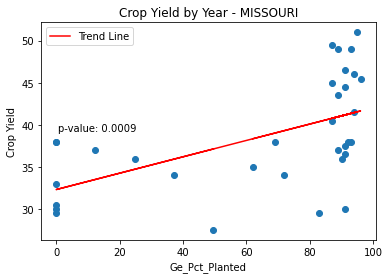

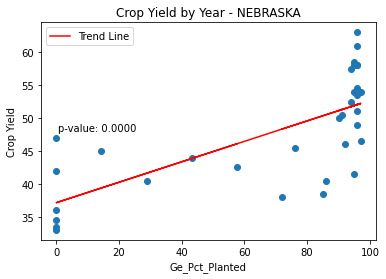

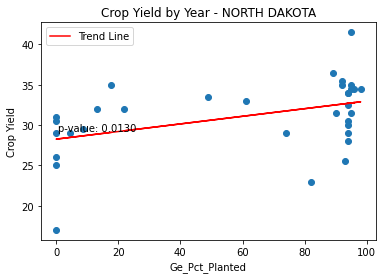

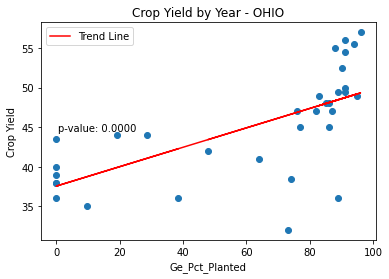

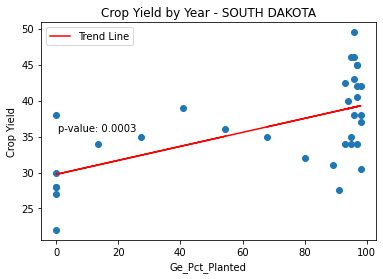

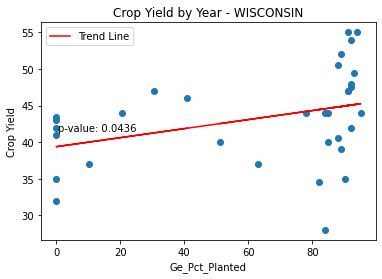

In [225]:
from scipy.stats import linregress

# Getting the list of unique states
states = soy_model_data['state_name'].unique()

# Plotting for each state
for state in states:
    # Filtering the data for the current state
    state_data = soy_model_data[soy_model_data['state_name'] == state]
    
    # Creating a new plot for each state
    plt.figure()
    
    # Creating the scatter plot for the current state
    plt.scatter(state_data['Ge_Pct_Planted'], state_data['yield'])
    
    # Fitting a linear regression line to the data points
    slope, intercept, r_value, p_value, _ = linregress(state_data['Ge_Pct_Planted'], state_data['yield'])
    trendline = intercept + slope * state_data['Ge_Pct_Planted']
    
    # Plotting the trend line
    plt.plot(state_data['Ge_Pct_Planted'], trendline, color='red', label='Trend Line')
    
    # Setting the title and labels for the current state
    plt.title(f'Crop Yield by Year - {state}')
    plt.xlabel('Ge_Pct_Planted')
    plt.ylabel('Crop Yield')
    
    # Notating the p-value on the plot
    plt.text(0.05, 0.5, f'p-value: {p_value:.4f}', transform=plt.gca().transAxes)
    
    # Showing the legend
    plt.legend()
    
    # Showing the plot for each state
    plt.show()

In [226]:
soy_model_data.year.unique()

array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021,
       2022, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999],
      dtype=int64)

## Outlier 

From the above plots we can observe that there aren't any states in the soy commodity that present as an outlier.

# Random Forest Models

Next, I will create the models to observe the variables that are going to be visualized in Tableau. Due to the limited text display functions within Tableau, and since Tableau does not have function to create multi-linear regression models, I will test in python and based on the results create the corresponding plots in Tableau. The project's intention is to create an easy to interpret dashboard that anyone, regardless of technical level, can understand and explore. Creating the models to check the statistical relevance will be key evidence for the stakeholders to make decisions with invested further into this topic.

After performing the analysis on Tableau to observe the linear relationships between the variables, it was observed that the PDSI(Palmer Drought Severity Index) when plotted against the yield per acre showed a polynomial pattern, a curved pattern in the shape of an upside down U. It appeared that this is a polynomial with 2 degrees. Because of that, I will be adding a squared term to the PDSI to account for this. Because I am including a squared term in the model, I will create a centered variable to help mitigate multicollinearity. 

Also, it is noted that the distribution within the Ge_Pct_Planted is not evenly distributed. A large amount of zero's exist for the time periods between 1986-1999 before genetically engineered seeds were being planted commercially, and years where data is not available (1996-1999). Because we know that the zero's do not come from multiple sources and are not missing data or unexplained, but to avoid zero inflation I am going to create groups that create categories for the increasing range of values. The values for years 1996-2000 will be interpolated by simply taking the first year value (year 2000) and incrementing equally down to zero in year 1995. This will give a better indicator for those years, rather than keeping them at 0.

## Creating additional variables

The next two modules create additional variables to test within the model. While random forest is a robust model, I will create variables to normalize some of the features and test to see what fits best.

In [227]:
# Center PDSI by subtracting its mean from each of its values
soy_model_data['PDSI_centered'] = soy_model_data['PDSI'] - soy_model_data['PDSI'].mean()
soy_model_data['TEMP_centered'] = soy_model_data['Average_Temperature'] - soy_model_data['Average_Temperature'].mean()
soy_model_data['PRECIP_centered'] = soy_model_data['Average_Inches_Rain'] - soy_model_data['Average_Inches_Rain'].mean()

# Add a squared term for the centered PDSI and Average Rainfall
soy_model_data['PDSI_centered_squared'] = soy_model_data['PDSI_centered'] ** 2
soy_model_data['TEMP_centered_squared'] = soy_model_data['TEMP_centered'] ** 2
soy_model_data['PRECIP_centered_squared'] = soy_model_data['PRECIP_centered'] ** 2

#creating the bins for GE % rating
bins = [-1, 0, 25, 50, 75, 100]

# Define the labels for each category
labels = ["ZERO","<25%", "<50%", "<75%", "<100%"]

# Use pd.cut to create the new variable
soy_model_data['GE_Seeds_Category'] = pd.cut(soy_model_data['Ge_Pct_Planted'], bins=bins, labels=labels)


## Feature Assessment

After testing the model with the above features, I found that these variables detracted from the models effectiveness, by a small degree, but I deemed they were not important for the model.

Instead, the base features are used which work best with this model.

In [228]:
#creating the relevant features for testing
relevant_features = ['state_name','Ge_Pct_Planted', 'PDSI', 'Average_Temperature', 'yield']
data = soy_model_data[relevant_features]
data = pd.get_dummies(data, columns=['state_name'])

# Split dataset into features and target variable
X = data.drop('yield', axis=1)
y = data['yield']

# Split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict crop yields
y_pred = model.predict(X_test)

MSE:  19.259744892473115
R-Squared:  0.7422583387423574


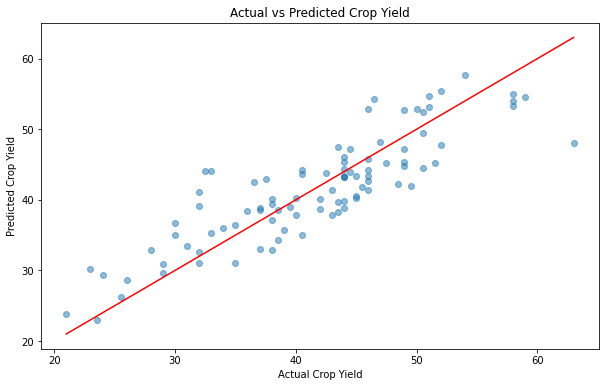

In [229]:
# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('MSE: ', mse)
print('R-Squared: ', r2)

# Plotting actuals vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Crop Yield')
plt.ylabel('Predicted Crop Yield')
plt.title('Actual vs Predicted Crop Yield')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Diagonal line
plt.show()

## Testing Feature Importance:
Understanding which variables most influence crop yield is likely just as important as the predictive capability of the model.

Relevance: Offers insight into the data and the model's decision-making process. In a domain like agriculture, this could lead to actionable insights.

In [230]:
importances = model.feature_importances_
features = X_train.columns

for feature, importance in zip(features, importances):
    print(f"Feature: {feature}, Importance: {importance}")

Feature: Ge_Pct_Planted, Importance: 0.317698967641399
Feature: PDSI, Importance: 0.1697004806545178
Feature: Average_Temperature, Importance: 0.25713017830800516
Feature: state_name_ARKANSAS, Importance: 0.003031145436720671
Feature: state_name_ILLINOIS, Importance: 0.016237956544813702
Feature: state_name_INDIANA, Importance: 0.00567274012071869
Feature: state_name_IOWA, Importance: 0.010779776912229713
Feature: state_name_KANSAS, Importance: 0.038119183629038406
Feature: state_name_MICHIGAN, Importance: 0.0029379781598586987
Feature: state_name_MINNESOTA, Importance: 0.00375839824109468
Feature: state_name_MISSISSIPPI, Importance: 0.0022661816993791314
Feature: state_name_MISSOURI, Importance: 0.011441333306111997
Feature: state_name_NEBRASKA, Importance: 0.009646445831574948
Feature: state_name_NORTH DAKOTA, Importance: 0.10756952980294593
Feature: state_name_OHIO, Importance: 0.0027517837494373475
Feature: state_name_SOUTH DAKOTA, Importance: 0.03861193707499506
Feature: state_nam

## Feature Assessment

The results from the feature importance analysis give us some interesting points to investigate further. The observations concluded are:

#### 1. Top Features by Importance:
Ge_Pct_Planted (31.7%): This is by far the most significant feature. It suggests that the proportion of genetically engineered seeds planted has the most considerable influence on crop yields. This could imply that genetically engineered seeds have a distinct performance profile when it comes to yield outcomes, maybe due to resistance to certain pests, diseases, or better adaptability to various soil types and weather conditions.

Average_Temperature (25.71%): Temperature plays a pivotal role in crop yield, impacting growth phases, moisture availability, pest activity, etc. Its high importance emphasizes the role of temperature in determining yields.

PDSI (16.97%): The Palmer Drought Severity Index measures prolonged and abnormally dry or wet periods. It's essential because drought or overly wet conditions can severely impact crop growth and development.

#### 2. State Specific Importances:
NORTH DAKOTA (10.75%): These states have considerably higher importance than other states, suggesting they may have distinct patterns or conditions that are especially relevant in determining crop yields. Perhaps there are unique weather conditions, soil types, or farming practices in these states that set them apart from others.

Most other states have feature importance values less than 1%, with a few exceptions like KANSAS (3.81%) and SOUTH DAKOTA (3.86%). This indicates that, after accounting for other factors like temperature, PDSI, and genetically engineered seed usage, the specific state becomes less crucial for the overall model. However, it doesn't mean the state isn't important; instead, it means the unique variance attributed solely to the state, after considering other features, is relatively low.

## Testing Residuals

Next we will look at the residuals against the predictions to access for heteroscedasticity. We will first visual the results in a plot, then run a Breusch Pagan analysis to statistically access the variables. 

We are running the Breusch Pagan with the assumptions:

Null Hypothesis (H0): Homoskedasticity is present (variance of the errors is constant).
Alternative Hypothesis (H1): Heteroskedasticity is present.

If the 'LM-Test p-value' or the 'F-Test p-value' is less than the significance level (0.05), then the null hypothesis of homoskedasticity is rejected, indicating the presence of heteroskedasticity in the data.

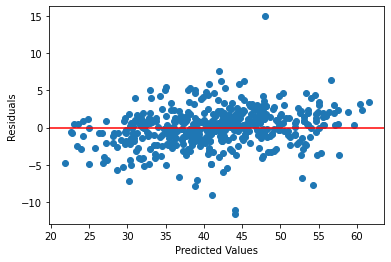

In [231]:
#plotting residuals against predicted values
predictions = model.predict(X)
residuals = y - predictions

plt.scatter(predictions, residuals)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

In [232]:
import statsmodels.api as sm
from statsmodels.compat import lzip
from statsmodels.stats.diagnostic import het_breuschpagan

predictions = model.predict(X)
residuals = y - predictions

bp_test = het_breuschpagan(residuals, X)

labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
result = dict(zip(labels, bp_test))

print(result)

{'LM Statistic': 25.330831341365997, 'LM-Test p-value': 0.06420153340825306, 'F-Statistic': 1.6133810153024453, 'F-Test p-value': 0.06172424768818806}


The results show that we cannot reject the null hypothesis (H0) in favor of the alternative. The LM-Test p-value and F-Test p-value both exceed the significance level of (0.05). This give us a good indication that the model does not have a strong presense of heteroscadasticity.

### OOB

Lastly we will calculate the OOB(Out-Of-Bag) score to see how well the model performs against the untrained samples. This can give us another validation metric for the model.

In [233]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, oob_score=True, random_state=42)
model.fit(X_train, y_train)

print("OOB Score:", model.oob_score_)

OOB Score: 0.6686160609340628


In [234]:
#adding the fitted values to the dataset for export
soy_model_data['Fitted Values'] = model.predict(X)

In [235]:
soy_model_data.to_csv('soy_model_results.csv')

## Overall Predictions vs Actuals

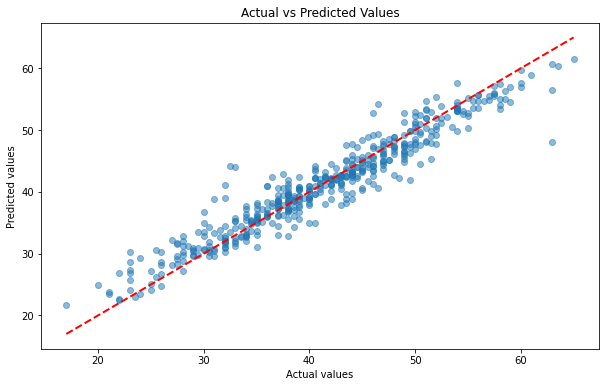

In [236]:
#creating the variables from the model
predicted_values = predictions
actual_values = soy_model_data['yield']

# Creating a scatter plot of actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(actual_values, predictions, alpha=0.5)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title(f'Actual vs Predicted Values')

# Plotting a line representing a perfect prediction
plt.plot([actual_values.min(), actual_values.max()],[actual_values.min(), actual_values.max()], color='red', linestyle='--', lw=2)

plt.show()

# Completed Analysis

The random forest models have been completed and the results will be exported into the Tableau dashboard to complete the visualization project.